## Линейные модели в машинном обучении

К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:
Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:

- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

1) Стандартизировали данные и убрали выбросы

2) Провели анализ данных

3) провели корреляционнный анализ для МО

4) Построили свою машинную обучение, на основе собрынных данных

5) Вывод

## Загрузка данных

In [1]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q

<div class="alert alert-info">
Добрый день, Кирилл. Спасибо за подсказку.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik import resources
from phik.report import plot_correlation_matrix

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error, 
    r2_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix)

from sklearn.preprocessing import OneHotEncoder, StandardScaler 

In [4]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep = ';', decimal = ',')
ferma_main.head(3)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет


In [5]:
ferma_main.columns

Index(['id', 'Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)',
       'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)', 'Порода',
       'Тип пастбища', 'порода папы_быка', 'Жирность,%', 'Белок,%',
       'Вкус молока', 'Возраст'],
      dtype='object')

In [6]:
ferma_main = ferma_main.rename(columns={
    'Удой, кг' : 'удой_кг', 
    'ЭКЕ (Энергетическая кормовая единица)' : 'эке',
    'Сырой протеин, г' : 'сырой_протеин_г',
    'СПО (Сахаро-протеиновое соотношение)' : 'спо',
    'Тип пастбища' : 'тип_пастбища',
    'порода папы_быка' : 'порода_папы_быка',
    'Жирность,%' : 'жирность_%',
    'Белок,%' : 'белок_%',
    'Вкус молока' : 'вкус_молока'})

ferma_main.columns = ferma_main.columns.str.lower()

ferma_main.columns

Index(['id', 'удой_кг', 'эке', 'сырой_протеин_г', 'спо', 'порода',
       'тип_пастбища', 'порода_папы_быка', 'жирность_%', 'белок_%',
       'вкус_молока', 'возраст'],
      dtype='object')

In [7]:
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', delimiter=';')
ferma_dad.head(3)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин


In [8]:
ferma_dad = ferma_dad.rename(columns={
    'Имя Папы' : 'имя_папы'})

ferma_dad.columns

Index(['id', 'имя_папы'], dtype='object')

In [9]:
cow_buy = pd.read_csv('/datasets/cow_buy.csv', delimiter=';')
cow_buy.head(3)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет


In [10]:
cow_buy = cow_buy.rename(columns={
    'Тип пастбища' : 'тип_пастбища', 
    'порода папы_быка' : 'порода_папы_быка',
    'Текущая_жирность,%' : 'жирность_%',
    'Текущий_уровень_белок,%' : 'белок_%'})

cow_buy.columns = cow_buy.columns.str.lower()

cow_buy.columns

Index(['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'жирность_%',
       'белок_%', 'возраст'],
      dtype='object')

Я выгрузил данные из трех источников, данные совпали как в тз.

- Я привел название столбцов к строчным буквам.
- Некоторые название я переименовал, сделал это потому что некоторые программы могут не понять запятые, поэтому я посавил нижнее подчеркивание.

##  Предобработка данных

In [11]:
def error(df):
    print(df.isnull().sum(), '\n')
    print('Кол-во явных дубликатов: ',df.duplicated().sum(), '\n')
    print('Тип данных: \n',df.dtypes)

In [12]:
error(ferma_main)

id                  0
удой_кг             0
эке                 0
сырой_протеин_г     0
спо                 0
порода              0
тип_пастбища        0
порода_папы_быка    0
жирность_%          0
белок_%             0
вкус_молока         0
возраст             0
dtype: int64 

Кол-во явных дубликатов:  5 

Тип данных: 
 id                    int64
удой_кг               int64
эке                 float64
сырой_протеин_г       int64
спо                 float64
порода               object
тип_пастбища         object
порода_папы_быка     object
жирность_%          float64
белок_%             float64
вкус_молока          object
возраст              object
dtype: object


In [13]:
duplicates = ferma_main[ferma_main.duplicated(keep=False)]
print("Дубликаты:")
duplicates

Дубликаты:


,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст
626,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


In [15]:
ferma_main.drop_duplicates(inplace=True)

In [16]:
ferma_main['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [17]:
cow_buy['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [18]:
replacement = {
    'Айдиалл': 'Айдиал'
}

ferma_main['порода_папы_быка'] = ferma_main['порода_папы_быка'].replace(replacement)

ferma_main['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [19]:
ferma_main['тип_пастбища'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

In [20]:
replacement = {
    'Равнинные': 'Равнинное'
}

ferma_main['тип_пастбища'] = ferma_main['тип_пастбища'].replace(replacement)

ferma_main['тип_пастбища'].unique()

array(['Равнинное', 'Холмистое'], dtype=object)

In [21]:
ferma_main['возраст'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

In [22]:
error(ferma_main)

id                  0
удой_кг             0
эке                 0
сырой_протеин_г     0
спо                 0
порода              0
тип_пастбища        0
порода_папы_быка    0
жирность_%          0
белок_%             0
вкус_молока         0
возраст             0
dtype: int64 

Кол-во явных дубликатов:  0 

Тип данных: 
 id                    int64
удой_кг               int64
эке                 float64
сырой_протеин_г       int64
спо                 float64
порода               object
тип_пастбища         object
порода_папы_быка     object
жирность_%          float64
белок_%             float64
вкус_молока          object
возраст              object
dtype: object


In [23]:
error(ferma_dad)

id          0
имя_папы    0
dtype: int64 

Кол-во явных дубликатов:  0 

Тип данных: 
 id           int64
имя_папы    object
dtype: object


In [24]:
ferma_dad['имя_папы'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

In [25]:
error(cow_buy)

порода              0
тип_пастбища        0
порода_папы_быка    0
имя_папы            0
жирность_%          0
белок_%             0
возраст             0
dtype: int64 

Кол-во явных дубликатов:  4 

Тип данных: 
 порода              object
тип_пастбища        object
порода_папы_быка    object
имя_папы            object
жирность_%          object
белок_%             object
возраст             object
dtype: object


In [26]:
duplicates = cow_buy[cow_buy.duplicated(keep=False)]
print("Дубликаты:")
duplicates

Дубликаты:


,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


In [27]:
cow_buy.head(3)

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет


In [28]:
box = ['жирность_%', 'белок_%']

for name in box:
    cow_buy[name] = cow_buy[name].str.replace(',', '.', regex=False)
    cow_buy[name] = cow_buy[name].astype('float')

In [29]:
cow_buy['порода'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [30]:
cow_buy['тип_пастбища'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [31]:
cow_buy['тип_пастбища'] = cow_buy['тип_пастбища'].str.title()
cow_buy['тип_пастбища'].unique()

array(['Холмистое', 'Равнинное'], dtype=object)

In [32]:
cow_buy['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [33]:
cow_buy['имя_папы'].unique()

array(['Геркулес', 'Буйный', 'Барин', 'Соловчик'], dtype=object)

In [35]:
cow_buy['возраст'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

In [36]:
error(cow_buy)

порода              0
тип_пастбища        0
порода_папы_быка    0
имя_папы            0
жирность_%          0
белок_%             0
возраст             0
dtype: int64 

Кол-во явных дубликатов:  4 

Тип данных: 
 порода               object
тип_пастбища         object
порода_папы_быка     object
имя_папы             object
жирность_%          float64
белок_%             float64
возраст              object
dtype: object


Мы обновили названия в полученных данных, удалили дубликаты, проверили наличие пропусков и удостоверились в правильности типов данных. В df cow_buy я решил оставить 4 дубликата, так как думаю, что есть похожие коровы или фермер хотел бы купить похожих коров по характеристикам.

## Исследовательский анализ данных

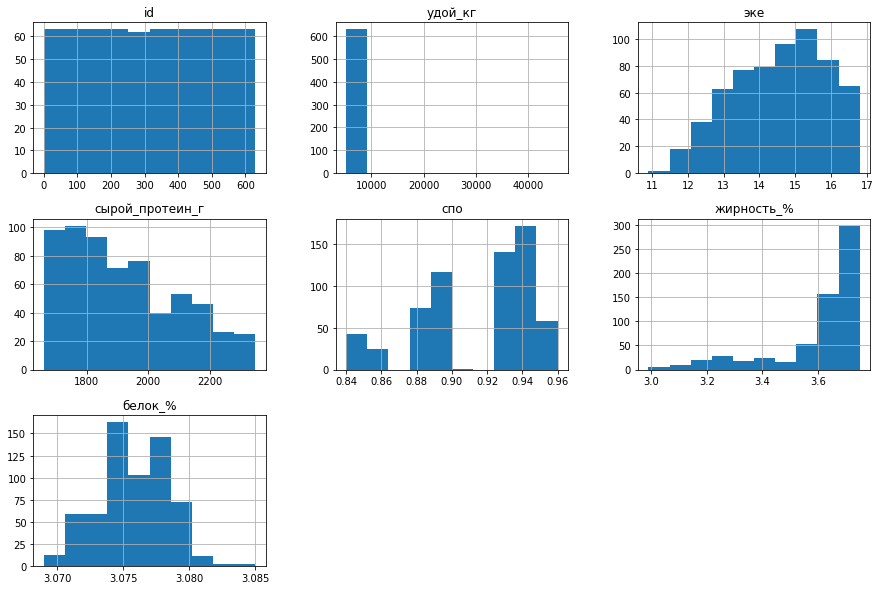

In [37]:
# Общая гистрограмма 'данные о стаде фермера'
ferma_main.hist(figsize=(15, 10));

In [38]:
# Диапазон 'данные о стаде фермера'
ferma_main.describe().T

,count,mean,std,min,25%,50%,75%,max
id,629.0,315.000000,181.720940,1.000,158.000,315.000,472.000,629.000
удой_кг,629.0,6188.750397,1644.795489,5204.000,5751.000,6133.000,6501.000,45616.000
эке,629.0,14.543879,1.306408,10.900,13.500,14.700,15.600,16.800
сырой_протеин_г,629.0,1923.364070,182.956251,1660.000,1771.000,1888.000,2062.000,2349.000
спо,629.0,0.913116,0.032203,0.840,0.890,0.930,0.940,0.960
жирность_%,629.0,3.603657,0.168656,2.990,3.590,3.650,3.720,3.750
белок_%,629.0,3.075671,0.002549,3.069,3.074,3.076,3.077,3.085


In [39]:
ferma_main = ferma_main[ferma_main['удой_кг'] <= 7500]

In [40]:
ferma_main.head(3)

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет


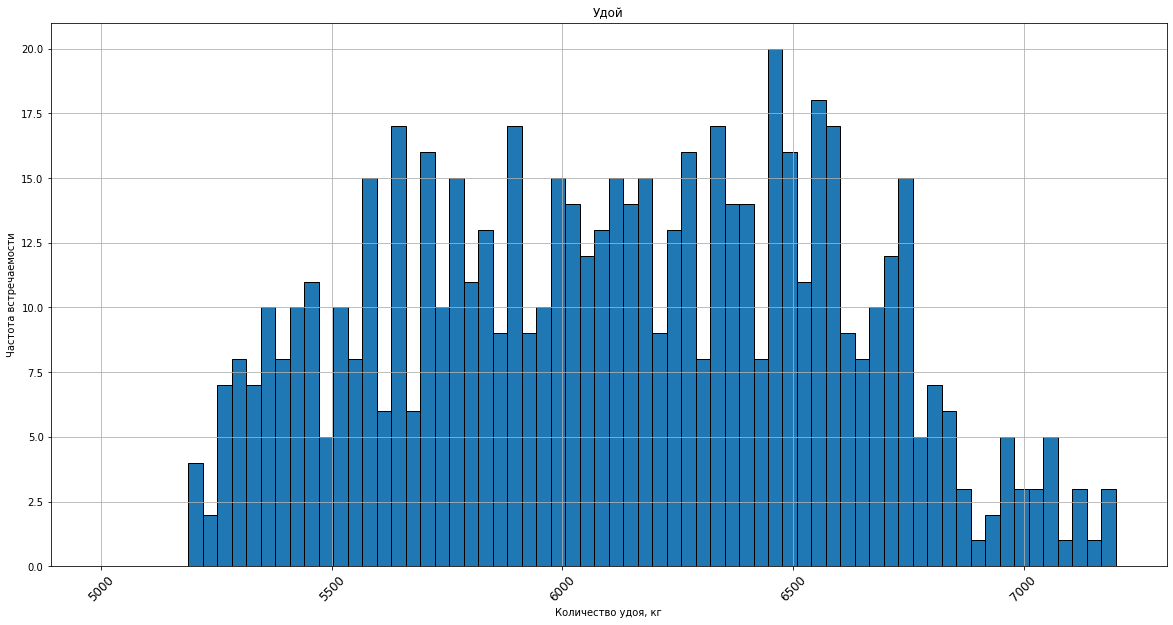

In [41]:
plt.figure(figsize=(20, 10))
plt.hist(ferma_main['удой_кг'], range=(5000, 7200), bins=70, edgecolor='black')

plt.title('Удой')

plt.xticks(rotation=45)
plt.xlabel('Количество удоя, кг')
plt.xticks(fontsize=12)

plt.ylabel('Частота встречаемости')
plt.grid(True)
plt.show();

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍  Точно 
</div> 
        


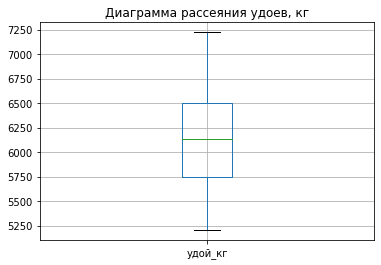

In [42]:
ferma_main.boxplot(column='удой_кг')
plt.title('Диаграмма рассеяния удоев, кг')
plt.grid(True)
plt.show();

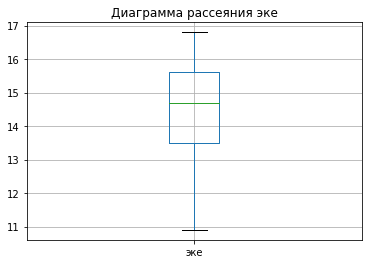

In [43]:
ferma_main.boxplot(column='эке')
plt.title('Диаграмма рассеяния эке')
plt.grid(True)
plt.show();

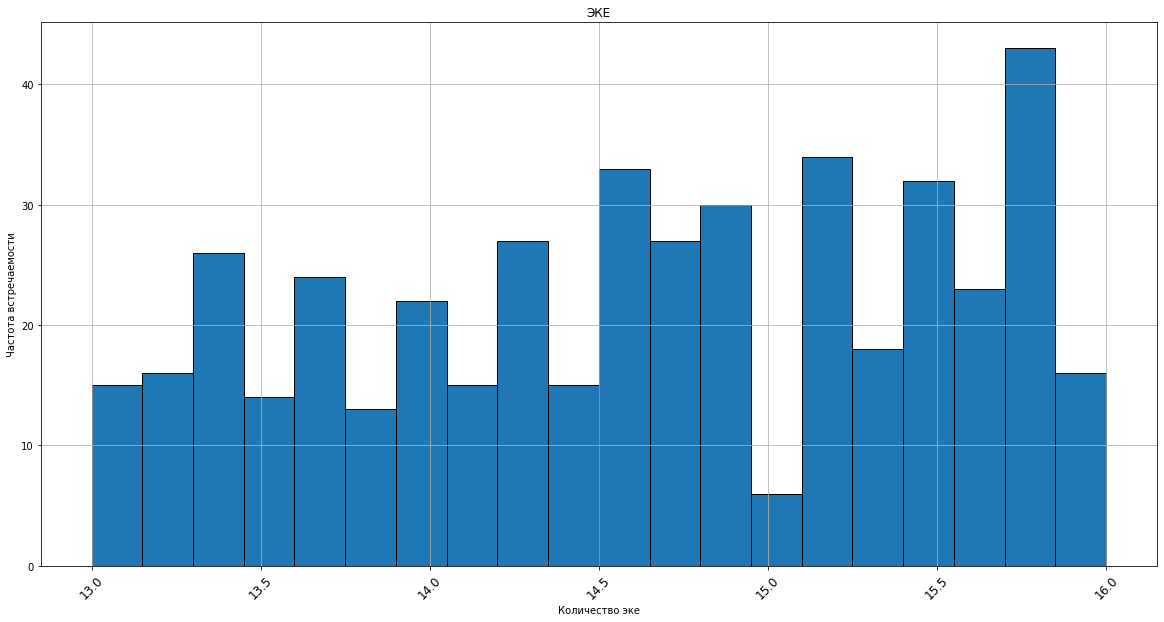

In [44]:
plt.figure(figsize=(20, 10))
plt.hist(ferma_main['эке'], range=(13, 16), bins=20, edgecolor='black')

plt.title('ЭКЕ')

plt.xticks(rotation=45)
plt.xlabel('Количество эке')
plt.xticks(fontsize=12)

plt.ylabel('Частота встречаемости')
plt.grid(True)
plt.show();

Можно заметить, что показатель "эке" преимущественно находится в диапазоне от 13.5 до 15.6

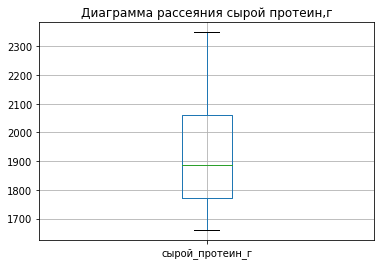

In [45]:
ferma_main.boxplot(column='сырой_протеин_г')
plt.title('Диаграмма рассеяния сырой протеин,г')
plt.grid(True)
plt.show();

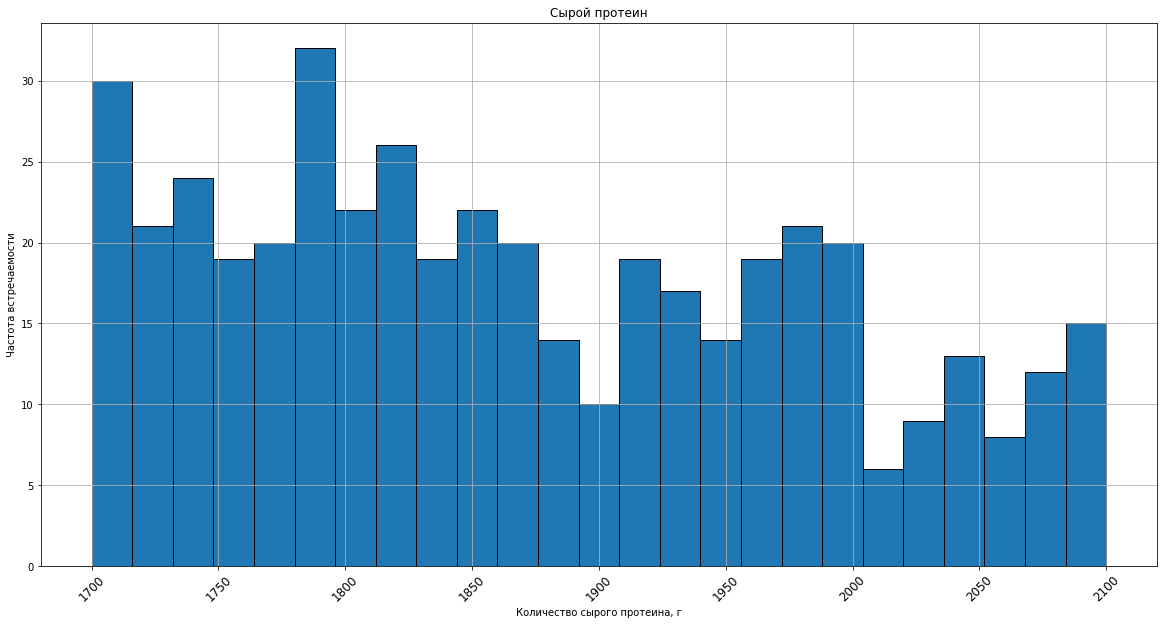

In [46]:
plt.figure(figsize=(20, 10))
plt.hist(ferma_main['сырой_протеин_г'], range=(1700, 2100), bins=25, edgecolor='black')

plt.title('Сырой протеин')

plt.xticks(rotation=45)
plt.xlabel('Количество сырого протеина, г')
plt.xticks(fontsize=12)

plt.ylabel('Частота встречаемости')
plt.grid(True)
plt.show();

Оснавное значение "Сырой протеин, г" находится в диапазоне от 1771 до 2062

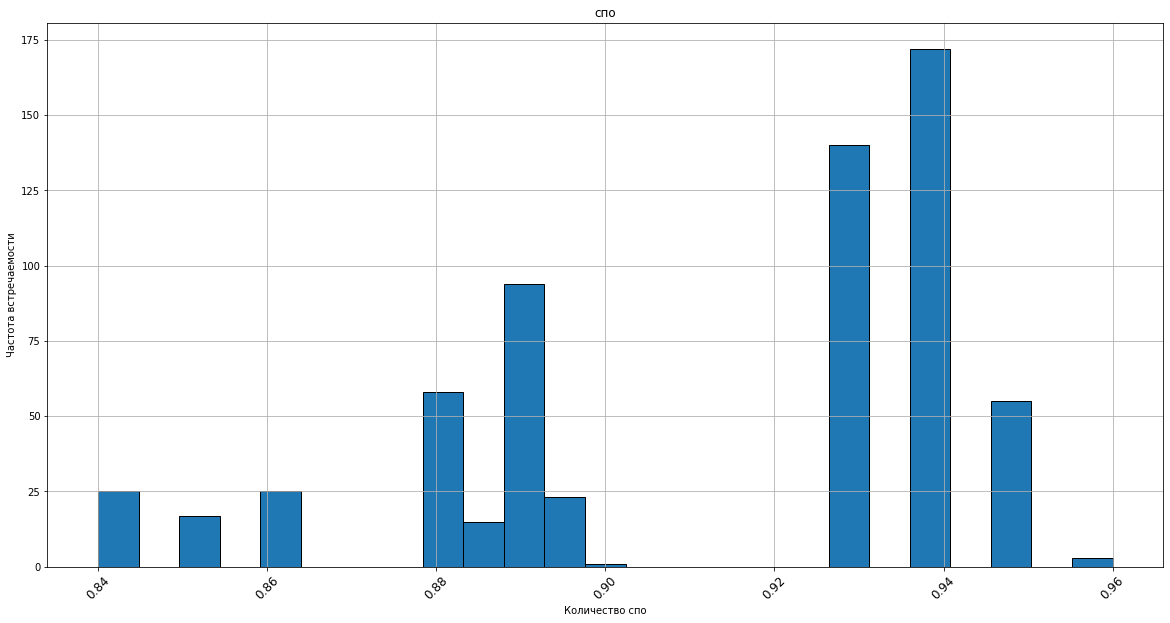

In [47]:
plt.figure(figsize=(20, 10))
plt.hist(ferma_main['спо'],  bins=25, edgecolor='black')

plt.title('спо')

plt.xticks(rotation=45)
plt.xlabel('Количество спо')
plt.xticks(fontsize=12)

plt.ylabel('Частота встречаемости')
plt.grid(True)
plt.show();

Можно заметить, что "спо" разделено на три подгруппы. Это от 0,84 - 0,86, 0,88 - 0,90 и 0,93 - 0,96.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Отлично. Здесь не наблюдаем нормального распределения.
</div>  


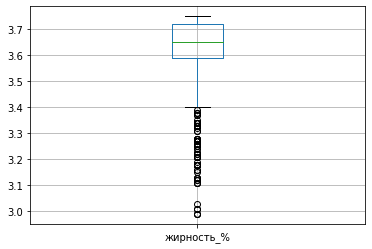

In [48]:
ferma_main.boxplot(column='жирность_%')
plt.grid(True)
plt.show();

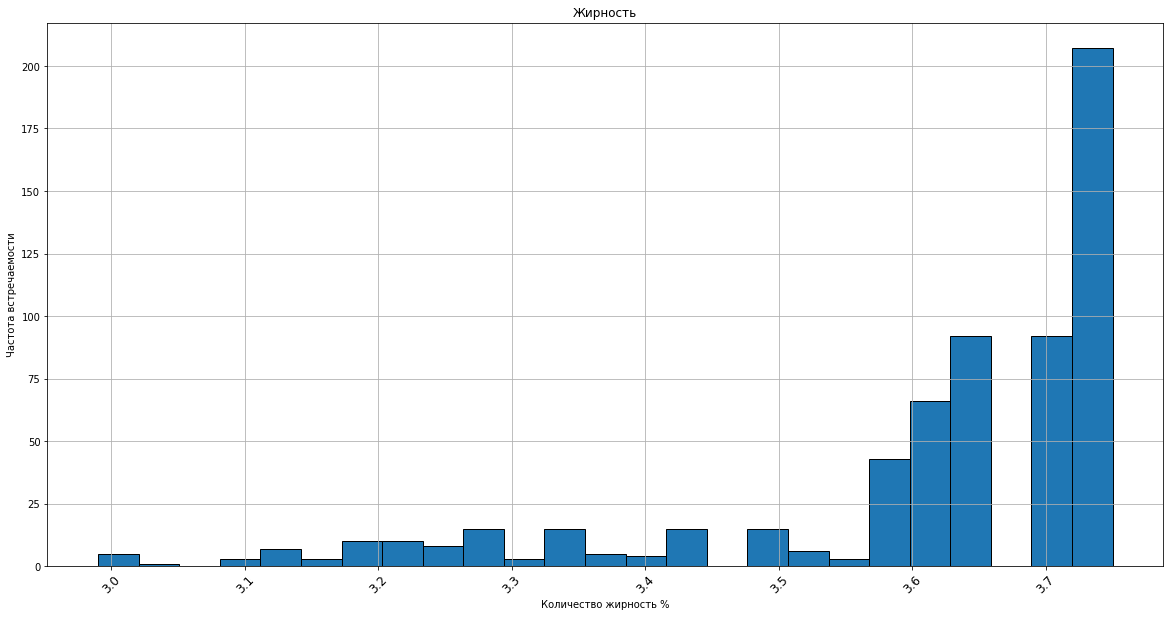

In [49]:
plt.figure(figsize=(20, 10))
plt.hist(ferma_main['жирность_%'],  bins=25, edgecolor='black')

plt.title('Жирность')

plt.xticks(rotation=45)
plt.xlabel('Количество жирность %')
plt.xticks(fontsize=12)

plt.ylabel('Частота встречаемости')
plt.grid(True)
plt.show();

По коробке с усами можно заметить, что у жирности много выбросов. Основной диапазон 3.59 - 3.72.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Данные в целом реалистичные, такие показатели жирности бывают. Однако распределение и здесь сложно назвать нормальным.
</div>  


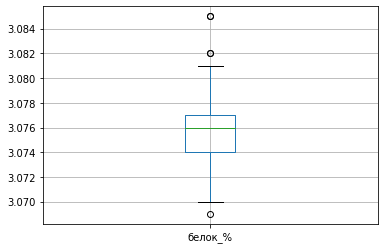

In [50]:
ferma_main.boxplot(column='белок_%')
plt.grid(True)
plt.show();

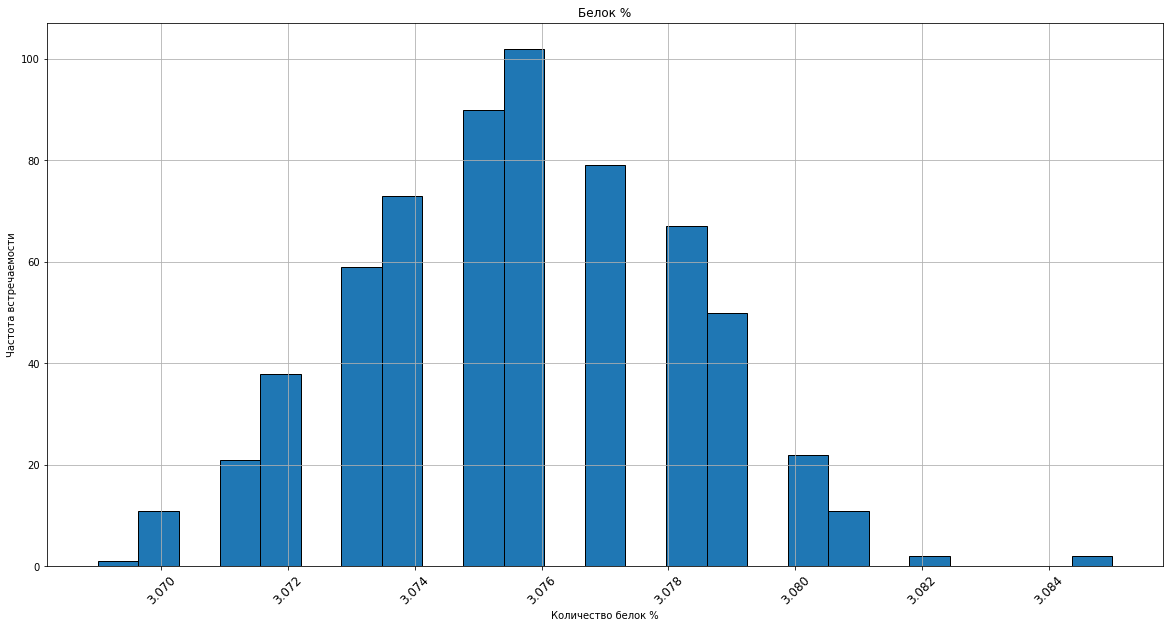

In [51]:
plt.figure(figsize=(20, 10))
plt.hist(ferma_main['белок_%'], bins=25, edgecolor='black')

plt.title('Белок %')

plt.xticks(rotation=45)
plt.xlabel('Количество белок %')
plt.xticks(fontsize=12)

plt.ylabel('Частота встречаемости')
plt.grid(True)
plt.show();

Белок имеет нормальное распределение, 3.074 - 3.077 и также можно заметить, что у него не много выбросов.

In [52]:
def graf(df, name, title, title2):
    data = df[name].value_counts()

    plt.figure( figsize=(20, 10))
    sns.barplot(x = data.index, y = data.values, palette = 'viridis')

    plt.title('{title} и их частота'.format(title=title))

    plt.xticks(rotation=45)
    plt.xlabel('{title2}'.format(title2=title2))
    plt.xticks(fontsize=12)

    plt.ylabel('Частота встречаемости')
    plt.grid(True)
    plt.show();

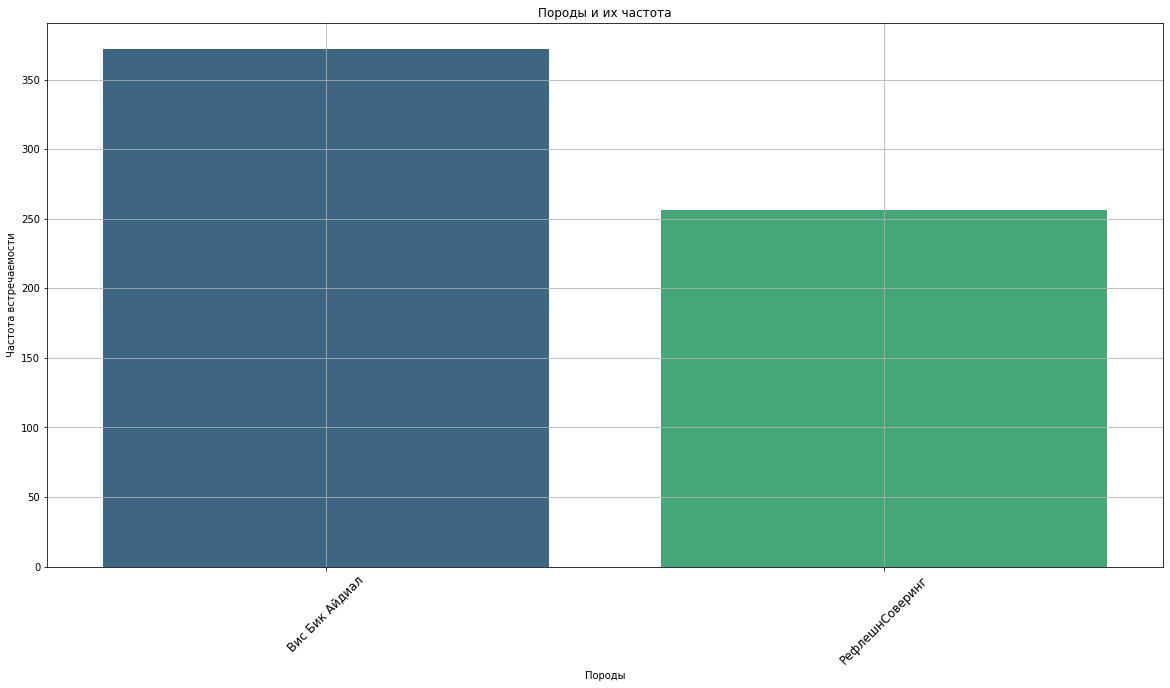

In [53]:
graf(df=ferma_main,name='порода', title='Породы', title2='Породы')

Преобладают из пород Вис Бик Айдиал.

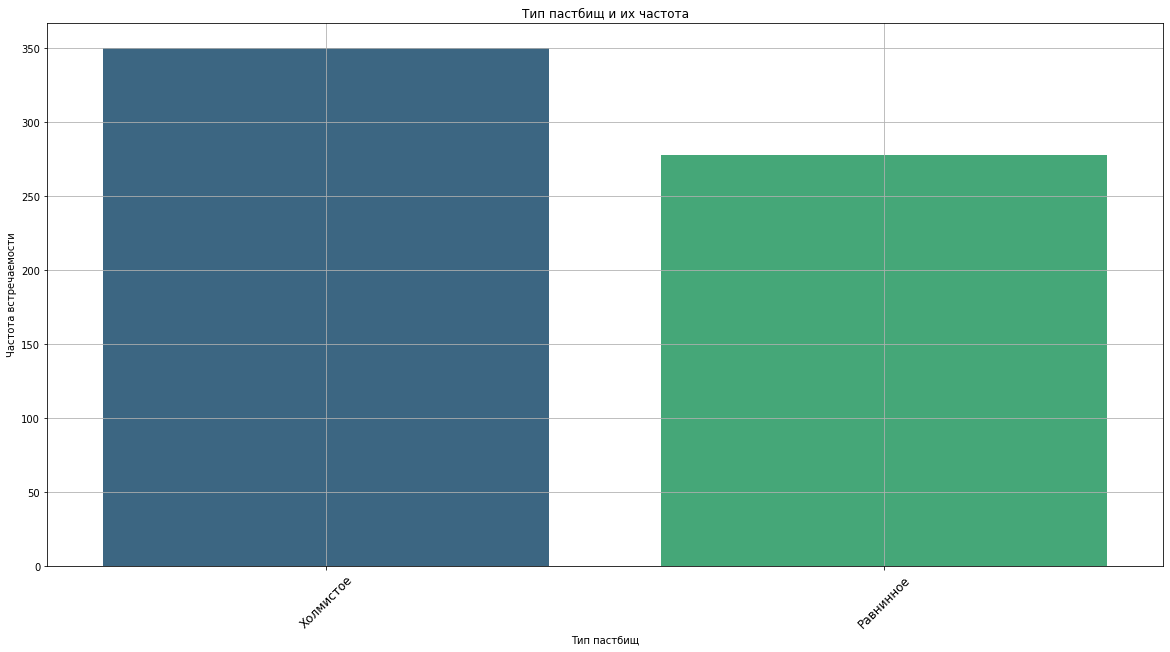

In [54]:
graf(df=ferma_main,name='тип_пастбища', title='Тип пастбищ', title2='Тип пастбищ')

Преобладает из пастбищ холмистое

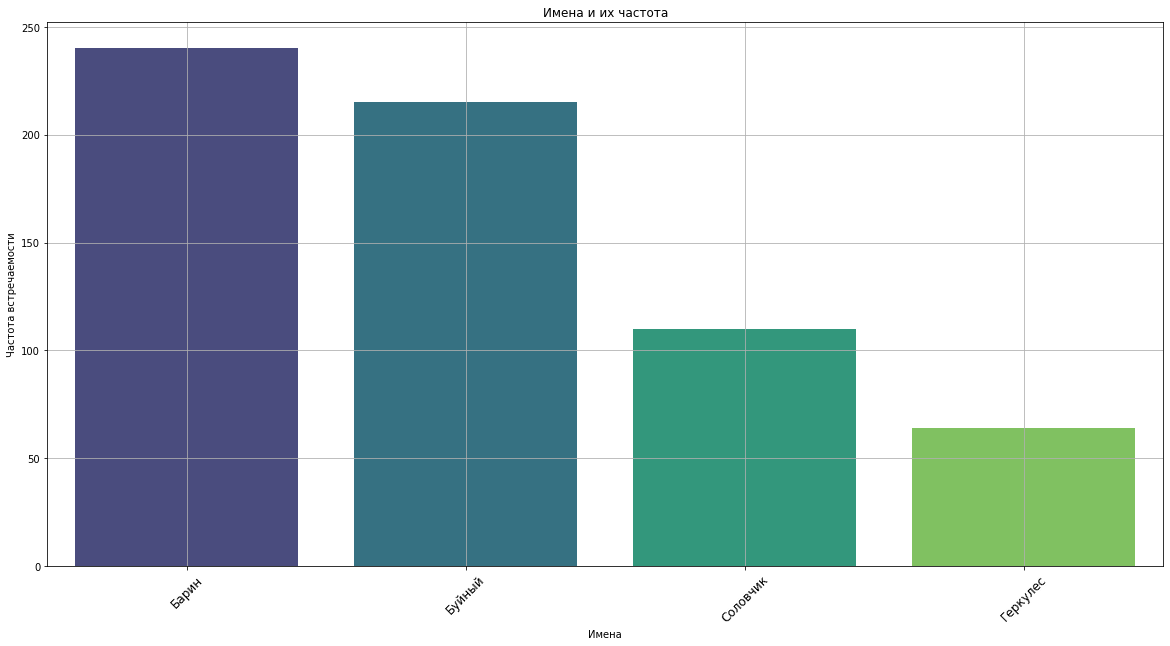

In [58]:
graf(df=ferma_dad, name='имя_папы', title='Имена', title2='Имена')

Чаще всегоотцами становятся Барин и Буйный

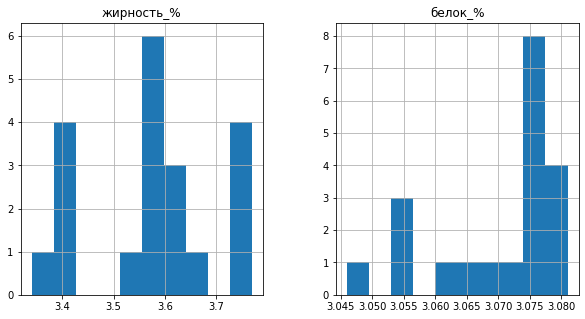

In [59]:
cow_buy.hist(figsize=(10, 5));

In [60]:
cow_buy.describe().T

,count,mean,std,min,25%,50%,75%,max
жирность_%,20.0,3.5775,0.126818,3.340,3.510,3.590,3.650,3.770
белок_%,20.0,3.0695,0.010339,3.046,3.064,3.074,3.076,3.081


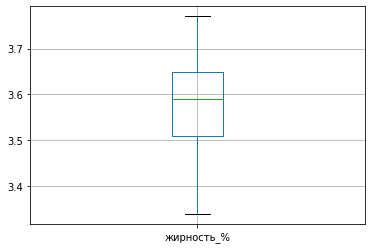

In [61]:
cow_buy.boxplot(column='жирность_%')
plt.grid(True)
plt.show();

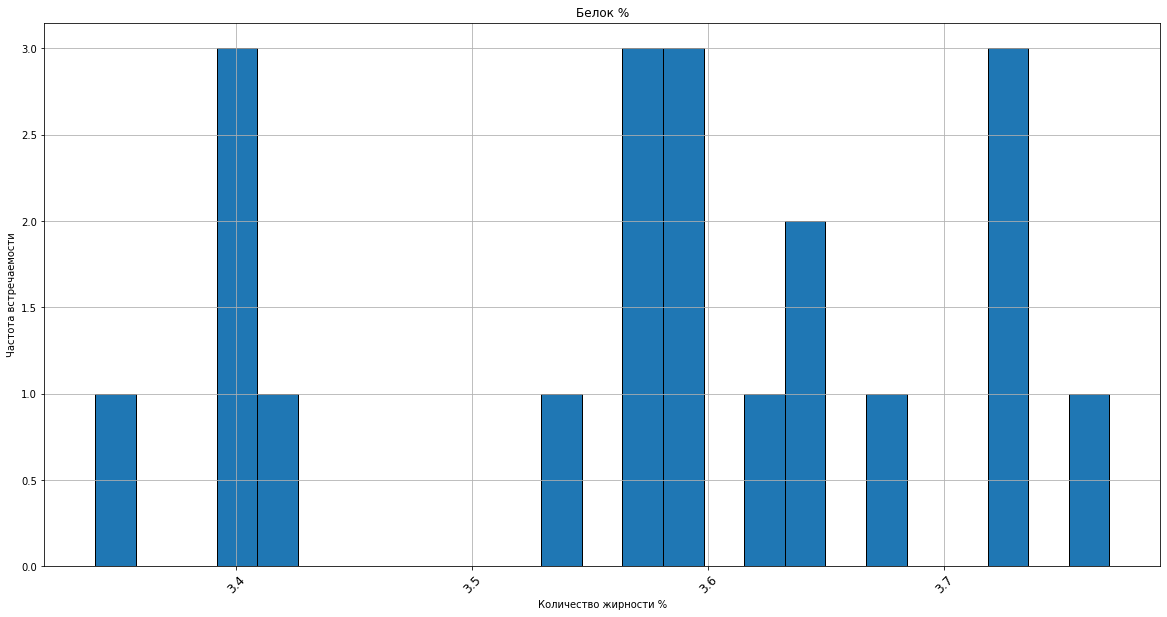

In [62]:
plt.figure(figsize=(20, 10))
plt.hist(cow_buy['жирность_%'], bins=25, edgecolor='black')

plt.title('Белок %')

plt.xticks(rotation=45)
plt.xlabel('Количество жирности %')
plt.xticks(fontsize=12)

plt.ylabel('Частота встречаемости')
plt.grid(True)
plt.show();

Диапазон жирности составляет 3.51 - 3.65

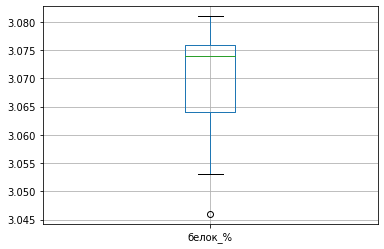

In [63]:
cow_buy.boxplot(column='белок_%')
plt.grid(True)
plt.show();

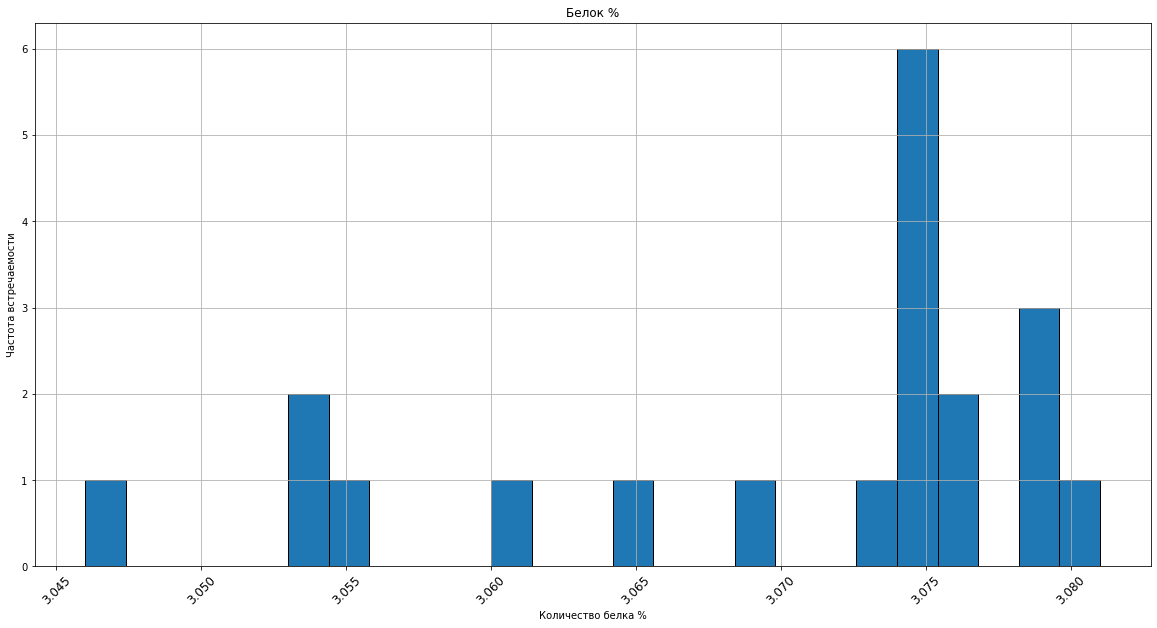

In [64]:
plt.figure(figsize=(20, 10))
plt.hist(cow_buy['белок_%'], bins=25, edgecolor='black')

plt.title('Белок %')

plt.xticks(rotation=45)
plt.xlabel('Количество белка %')
plt.xticks(fontsize=12)

plt.ylabel('Частота встречаемости')
plt.grid(True)
plt.show();

Диапазон белок составляет 3.064 - 3.076

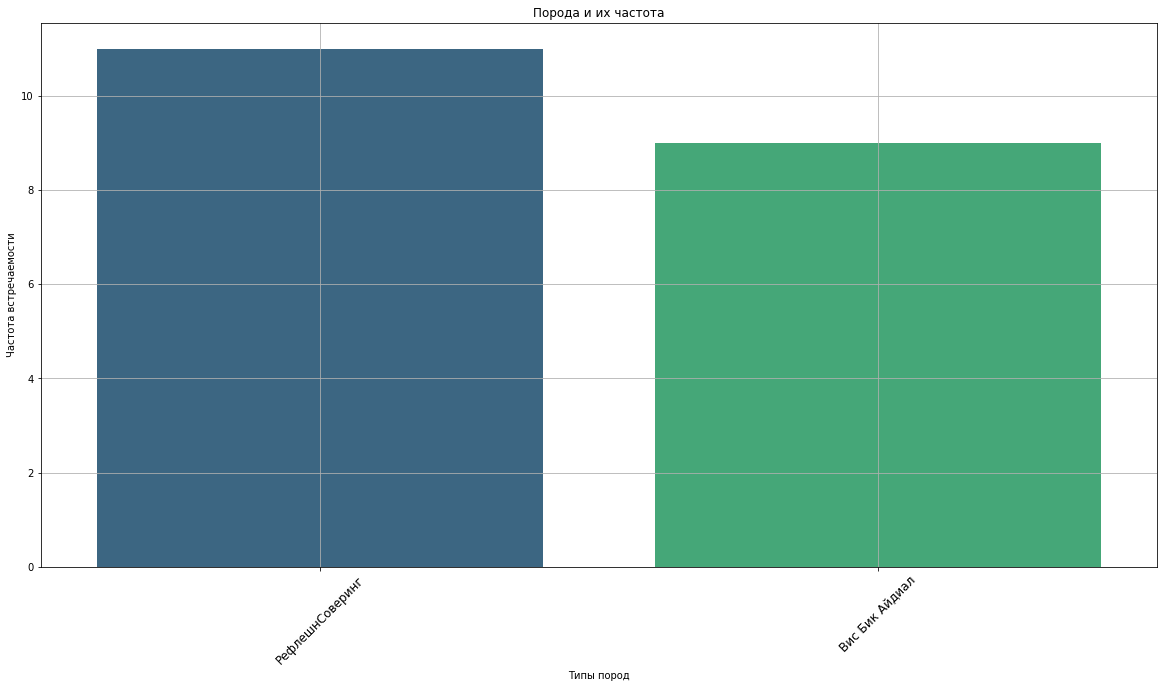

In [65]:
graf(df=cow_buy, name='порода', title='Порода', title2='Типы пород')

Породы коров представлены примерно в равных пропорциях.

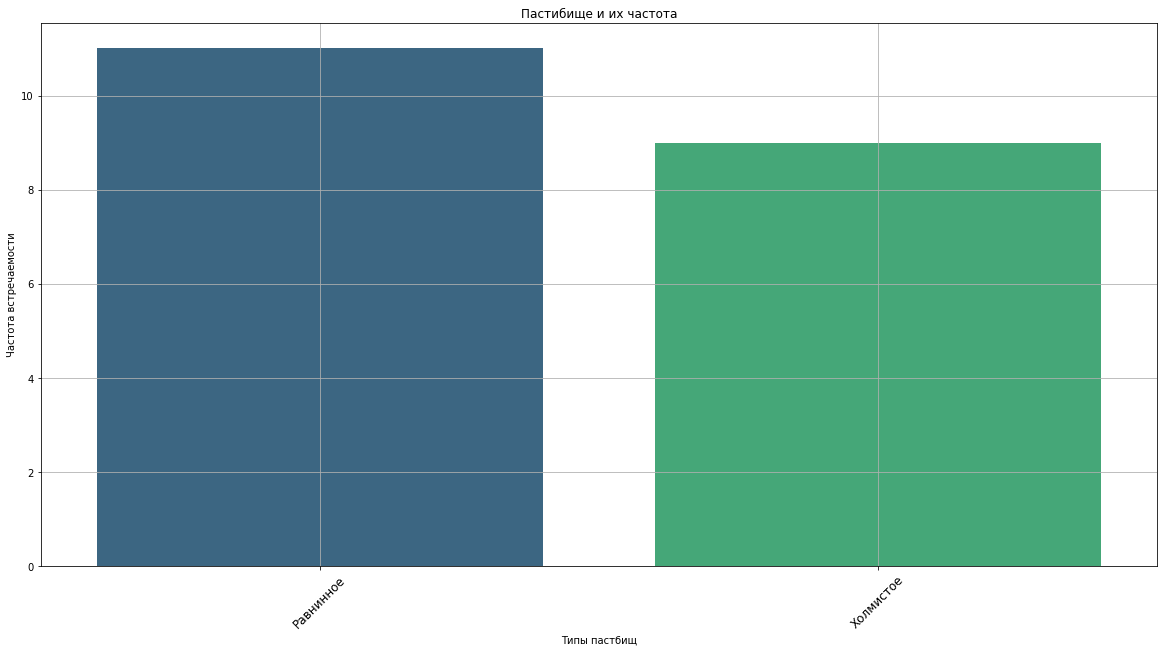

In [66]:
graf(df=cow_buy, name='тип_пастбища', title='Пастибище', title2='Типы пастбищ')

Типы пастбищ распределены довольно равномерно

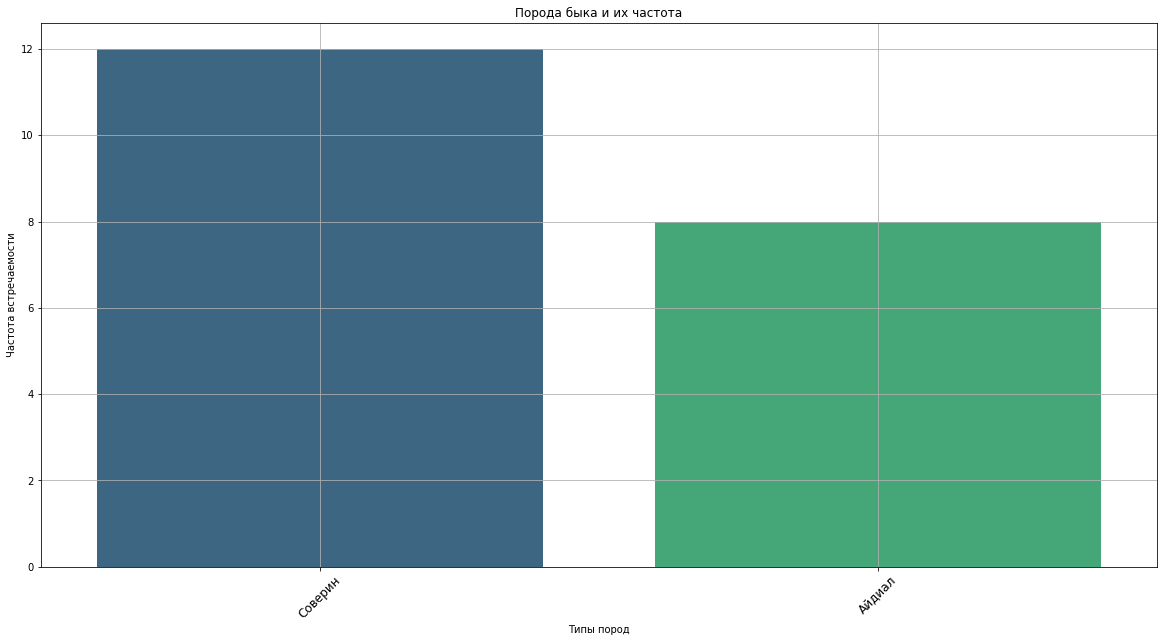

In [67]:
graf(df=cow_buy, name='порода_папы_быка', title='Порода быка', title2='Типы пород')

Из пород быков преобладают Соверин

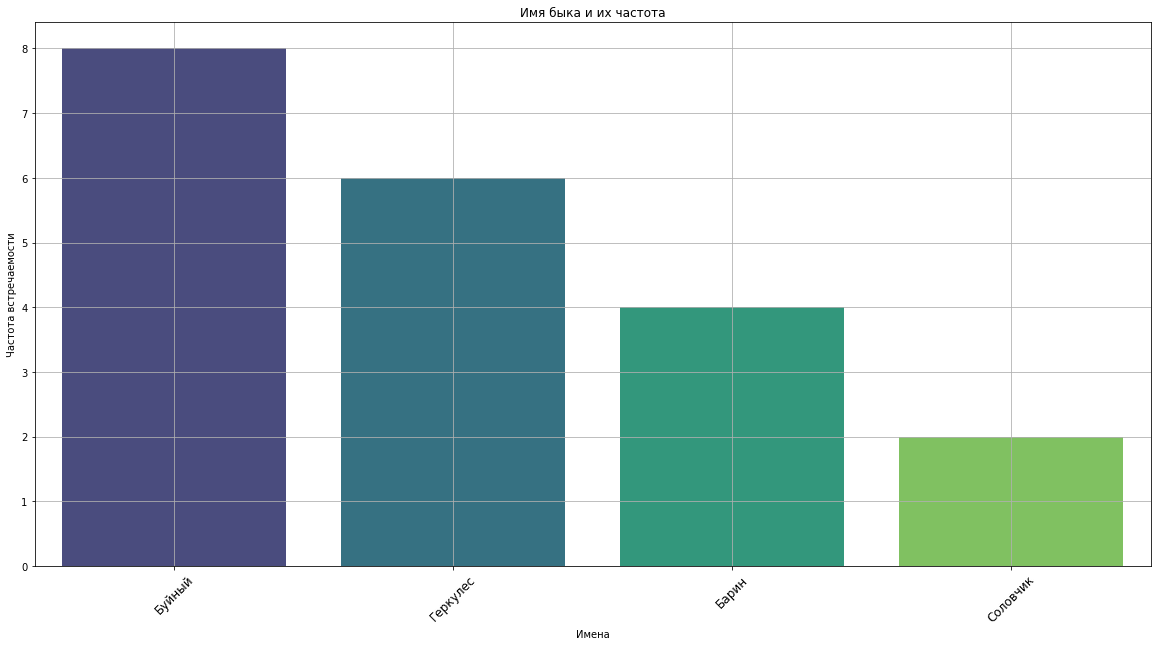

In [68]:
graf(df=cow_buy, name='имя_папы', title='Имя быка', title2='Имена')

Для покупки фермер выбрал коров чьи отцы были, буйный и геркулес

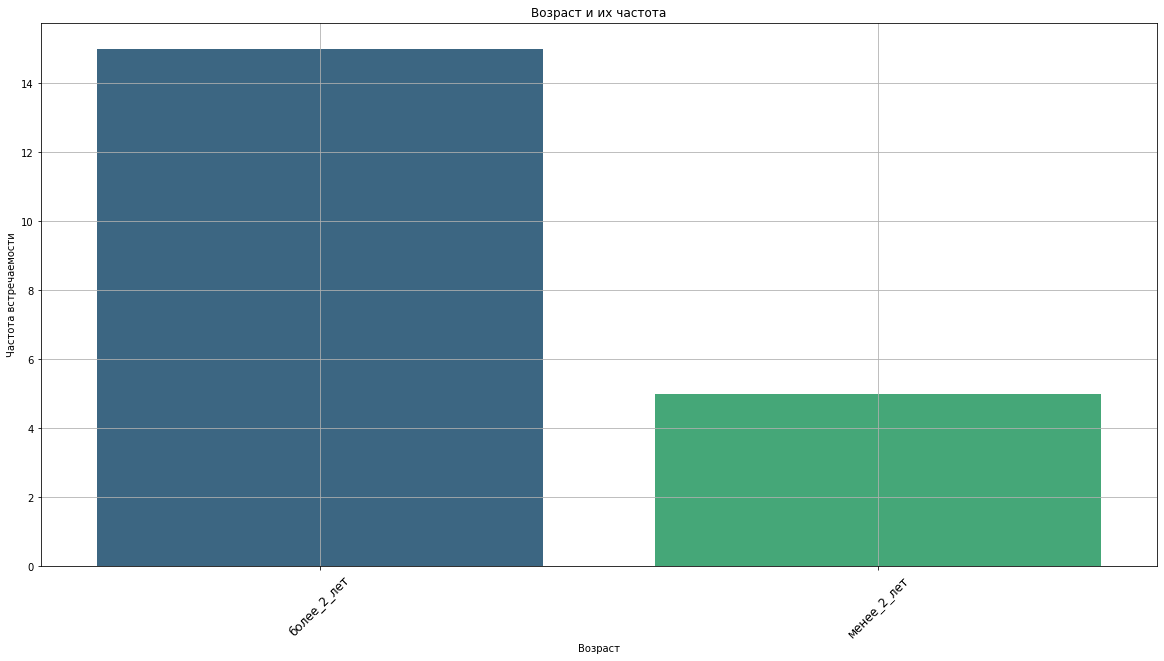

In [69]:
graf(df=cow_buy, name='возраст', title='Возраст', title2='Возраст')

Преобладают коровы более двух лет

- В данных было выявлин лиш один выброс, связанный с удоем.

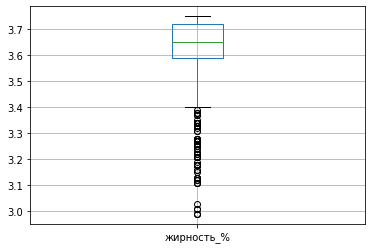

- Из выбрасов по ящику с усами можно назвать только данные у самого фермера по "жирности". Я решил Их не менять.
- У всех остальных данных я не нашел выбросы или аномалии.

Данные по ферме:

- Медиана удоя превышает 6000 кг.
- Преобладающей является порода коров "Вис Бик Айдиал".
- Наиболее распространённым типом пастбища является холмистый.
- Почти в равной мере распределены коровы по вкусу, но преобладают "вкусные".
- Большинство коров старше 2 лет.
- Таблица с именами отцов коров показывает следующее распределение: первое место занимает Барин, второе - Буйный, третье - Соловчик, четвертое - Геркулес.
- Все данные кроме "белок_%", не имеют нормальное распределение.

Данные по закупке:

- Из пород быков преобладают Соверин.
- Среди отцов коров первое место занимает Буйный, второе - Геркулес, далее следуют Барин и Соловчик.
- Выбрасов по показателям коров не было.

## Корреляционный анализ

In [70]:
def func_cor(df, column):
    return pd.get_dummies(df, columns=column)

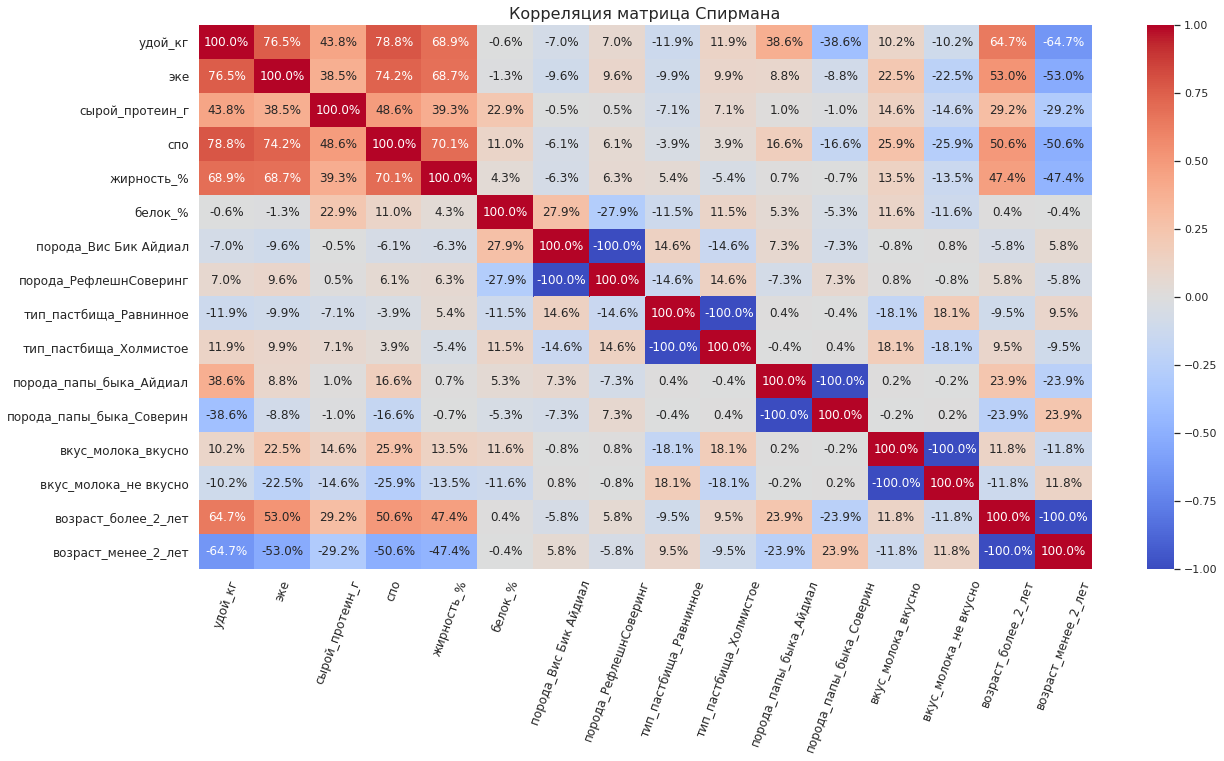

In [72]:
df = func_cor(df=ferma_main[['удой_кг', 'эке', 'сырой_протеин_г', 'спо', 'порода',
       'тип_пастбища', 'порода_папы_быка', 'жирность_%', 'белок_%',
       'вкус_молока', 'возраст']], column=['порода', 'тип_пастбища', 'порода_папы_быка','вкус_молока', 'возраст'])

sns.set(rc={"figure.figsize": (20, 10)})
ax = sns.heatmap(df.corr(method='spearman'), annot=True, fmt='.1%', cmap="coolwarm")

ax.tick_params(axis='x', labelrotation=70, labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.title('Корреляция матрица Спирмана', fontsize=16);

По кореляции спирмана рассмотри удой и вкус, поскольку мы их будем предсказывать:

Удой:
- Имеет зависимость с эке 76.5%, сырой_протеин_г 43.8%, спо 78.8%, жирность_% 68.9%, породы папы Айдиал 38.6% и обратная зависимость -38.6%, возраст более 2 лет 64.7% и  возраст менее 2 лет -64.7%. Остальные не имеют зависимоть или ими можно пренебречь.

Вкусное молоко:
- Удой 10.2%, эке 22.5%, спо 25.9%, пастбище равниное -18.1% и пастбище холмистое 18.1%. Остальное я не расматривал из-за низкой зависсимости.

Не вкусное молоко:
- Удой -10.2%, эке -22.5%, спо -25.9%, пастбище равниное 18.1% и пастбище холмистое -18.1%. Остальное я не расматривал из-за низкой зависсимости.

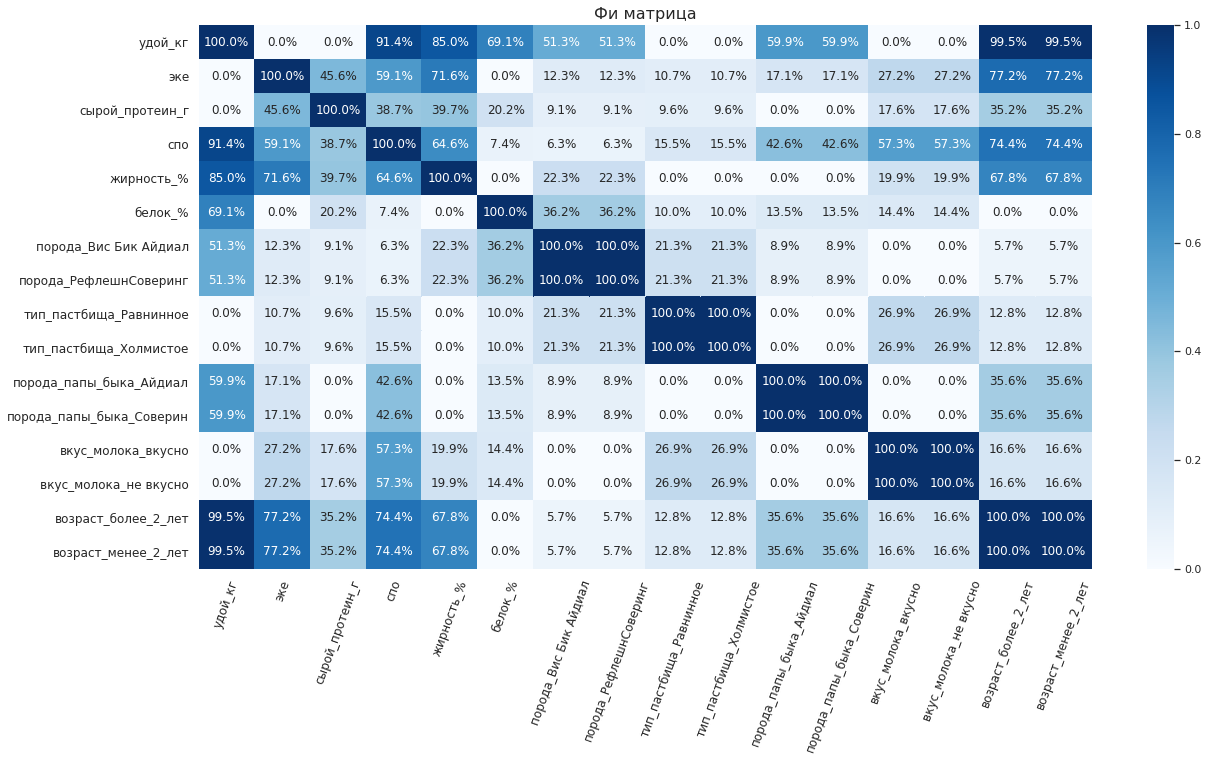

In [73]:
sns.set(rc={"figure.figsize": (20, 10)})
ax = sns.heatmap(df.phik_matrix(interval_cols=['эке', 'сырой_протеин_г', 'спо', 'жирность_%', 'белок_%']), annot=True, fmt='.1%', cmap="Blues")

ax.tick_params(axis='x', labelrotation=70, labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.title('Фи матрица', fontsize=16);

По матрице фи рассмотри удой и вкус, поскольку мы их будем предсказывать:

Удой:

- Имеет зависимость с спо 91.4%, жирность% 85.0%, белок% 69.1%, породы папы 51.3%, породы папы быка 59.9%, возраст 99.5%.

Вкус молока:

- Имеет зависимость с эке 27.2%, спо 57.3%,  тип пастбищ 26.9%, возраст 16.6%.

In [74]:
def graph_corr(df, x, y):
    plt.figure(figsize=(13, 8))
    sns.scatterplot(data=df, x=x, y=y, hue='порода', style='порода', s=100, palette='deep')

    df_corr = round(df[x].corr(df[y], method='spearman'), 3)
    
    plt.title('Диаграммы рассеяния между {x} и {y}'.format(x=x, y=y), fontsize=16, fontweight="normal", color='black')
    plt.xlabel('{x} \n Корреляция Пирсона {corr}'.format(x=x, corr=df_corr), fontsize=14, fontweight="normal", color='black')
    plt.ylabel('{y}'.format(y=y), fontsize=14, fontweight="normal", color='black')
    plt.grid(True)
    
    plt.tight_layout()
    
    plt.show();

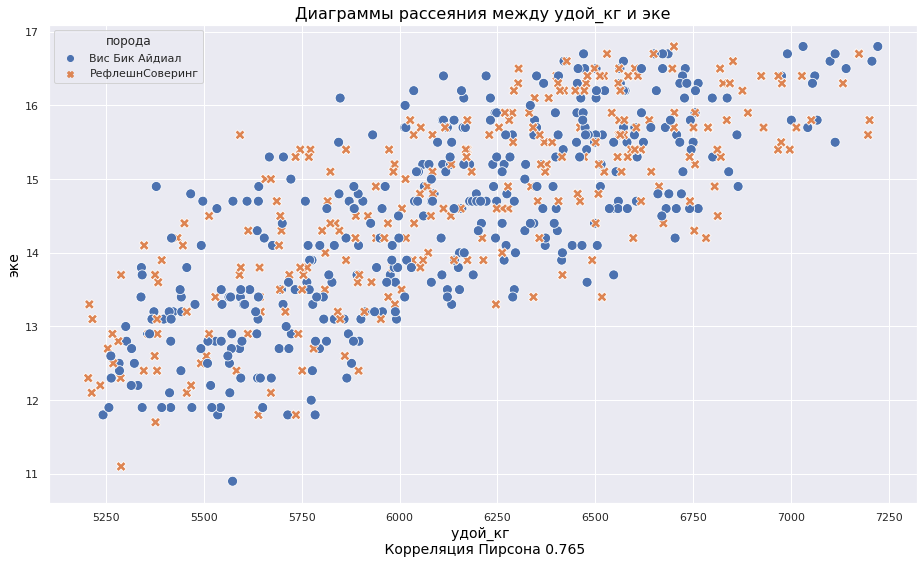

In [75]:
graph_corr(df=ferma_main, x='удой_кг', y='эке')

Можно звметить корреляцию между удой и эке

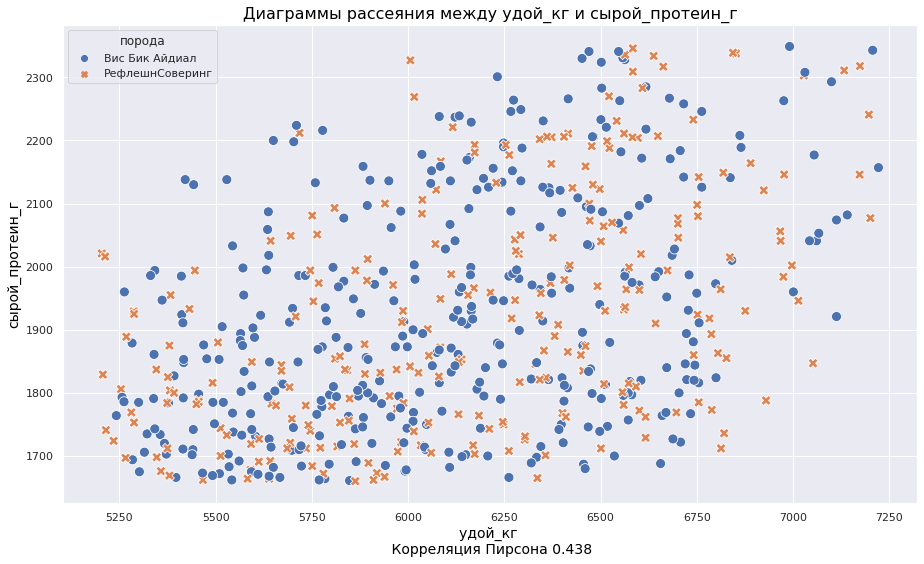

In [76]:
graph_corr(df=ferma_main, x='удой_кг', y='сырой_протеин_г')

Между протеином и удой слабо выраженная корреляция.

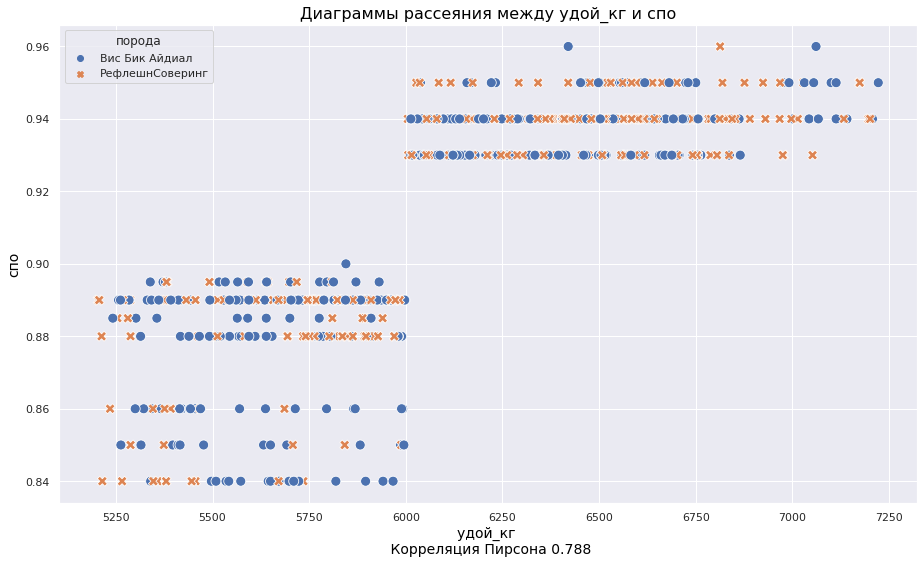

In [77]:
graph_corr(df=ferma_main, x='удой_кг', y='спо')

Корреляция спо и удой есть, но данные разбиты на два столбца, поэтому мы имеем тенденцию к кластеризации.

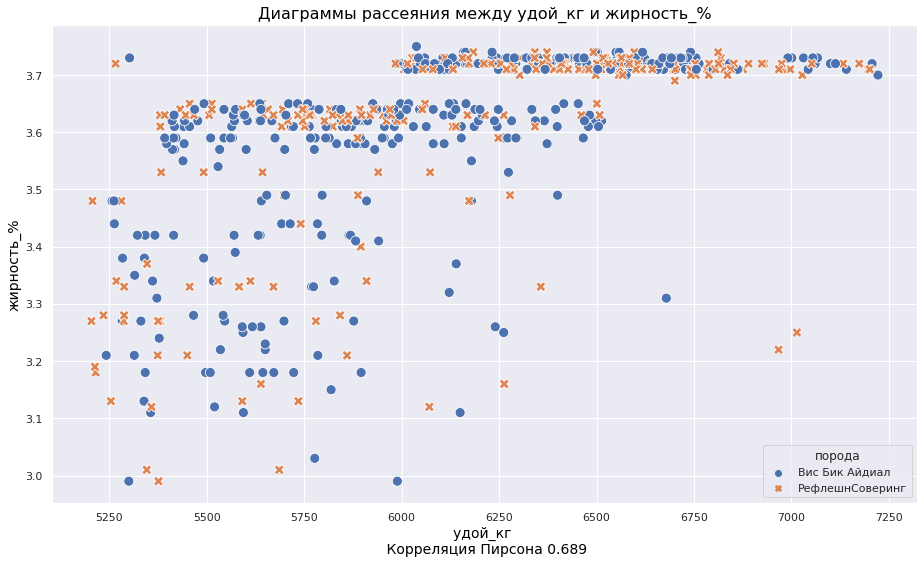

In [78]:
graph_corr(df=ferma_main, x='удой_кг', y='жирность_%')

Корреляция жирность% и удой есть, но данные тоже разбиты на два столбца, поэтому мы имеем тенденцию к кластеризации.

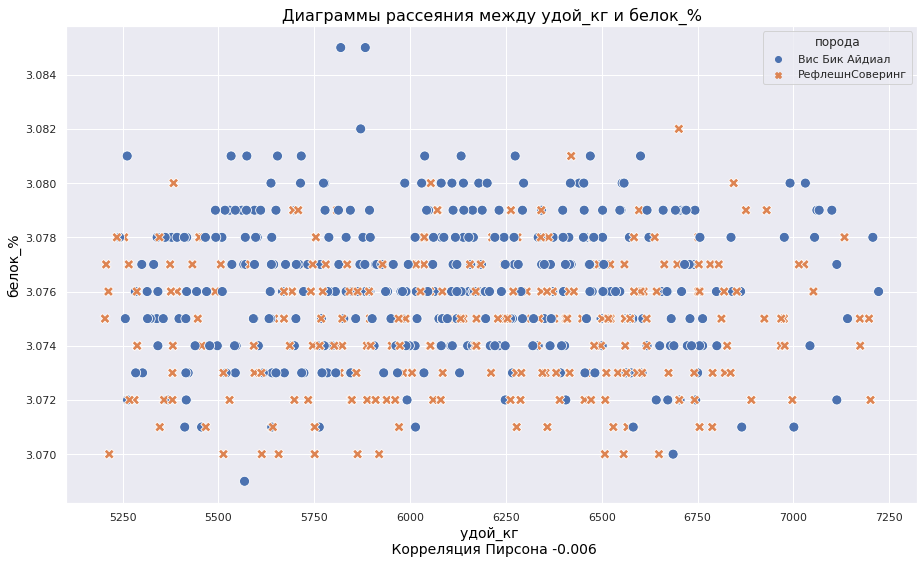

In [79]:
graph_corr(df=ferma_main, x='удой_кг', y='белок_%')

Корреляции между белок% и удой отсутсвует.

По кореляции спирмана рассмотрим удой и вкус, поскольку мы их будем предсказывать:

Удой:

Имеет зависимость:
- эке 76.5%
- сырой_протеин_г 43.8% спо 78.8%
- жирность% 68.9%
- породы папы Айдиал 38.6% и обратная зависимость -38.6%
- возраст более 2 лет 64.7% и возраст менее 2 лет -64.7% 
- Остальные параметры не имеют зависимоть или ими можно пренебречь.

Вкусное молоко:

- Удой 10.2%
- эке 22.5%
- спо 25.9%
- пастбище равниное -18.1% и пастбище холмистое 18.1%
- Остальные параметры я не расматривал из-за низкой зависсимости.

Не вкусное молоко:

- Удой -10.2%
- эке -22.5%
- спо -25.9%
- пастбище равниное 18.1% и пастбище холмистое -18.1%
- Остальное я не расматривал из-за низкой зависсимости.

По матрице фи рассмотри удой и вкус, поскольку мы их будем предсказывать:

Удой:

Имеет зависимость:
- спо 91.4%
- жирность% 85.0%
- белок% 69.1%
- породы папы 51.3%
- породы папы быка 59.9%
- возраст 99.5%

Вкус молока:

Имеет зависимость:
- эке 27.2%
- спо 57.3%
- тип пастбищ 26.9%
- возраст 16.6%.

Могу предположить вкусовые предпочения крайне субьективные качество, поэтому циферно тяжело найти зависимость.
Если говорить про мультиколлинеарность, то при корреляции пирсона ее не заметно. А в матрице фи только удой спо 91.4% и возрастат 99.5%   


## Обучение модели линейной регрессии

In [80]:
ferma_main['возраст'] = (ferma_main['возраст'] == 'более_2_лет').astype(int)

In [ ]:
def linal_ydoi(df, num_col, word_col, delet, y):
    X = df.drop(delet, axis=1)
    y = df[y]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col])
    X_test_scaled = scaler.transform(X_test[num_col])

    encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
    X_train_ohe = encoder.fit_transform(X_train[word_col])
    X_test_ohe = encoder.transform(X_test[word_col])
    encoder_col_names = encoder.get_feature_names_out()

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_final = pd.concat([pd.DataFrame(X_train_scaled, columns=num_col), X_train_ohe.reset_index(drop=True)], axis=1)

    X_test_final = pd.concat([pd.DataFrame(X_test_scaled, columns=num_col), X_test_ohe.reset_index(drop=True)], axis=1)

    model_lr = LinearRegression(positive=True)
    model_lr.fit(X_train_final, y_train)

    predictions = model_lr.predict(X_test_final)
    
    return (y_test, predictions, scaler, encoder, model_lr,  X_test_final)


In [ ]:
def grafic(y_test, predictions):
    
    residuals = y_test - predictions
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    axes[0].hist(residuals, bins=50)
    axes[0].set_title('Гистограмма распределения остатков',fontweight="normal", color='black')
    axes[0].set_xlabel('Остатки',fontweight="normal", color='black')

    axes[1].scatter(predictions, residuals)
    axes[1].set_xlabel('Предсказания модели',fontweight="normal", color='black')
    axes[1].set_ylabel('Остатки',fontweight="normal", color='black')
    axes[1].set_title('Анализ дисперсии',fontweight="normal", color='black')
    plt.show()
    
    print("RMSE:", round(mean_squared_error(y_test, predictions, squared=False), 5))
    print("MSE:", round(mean_squared_error(y_test, predictions), 5))
    print("MAE:", round(mean_absolute_error(y_test, predictions), 5))
    print("R²:", round(r2_score(y_test, predictions), 3), end='\n\n')
    
    print('Описательная статистика ошибок')
    print(residuals.describe())

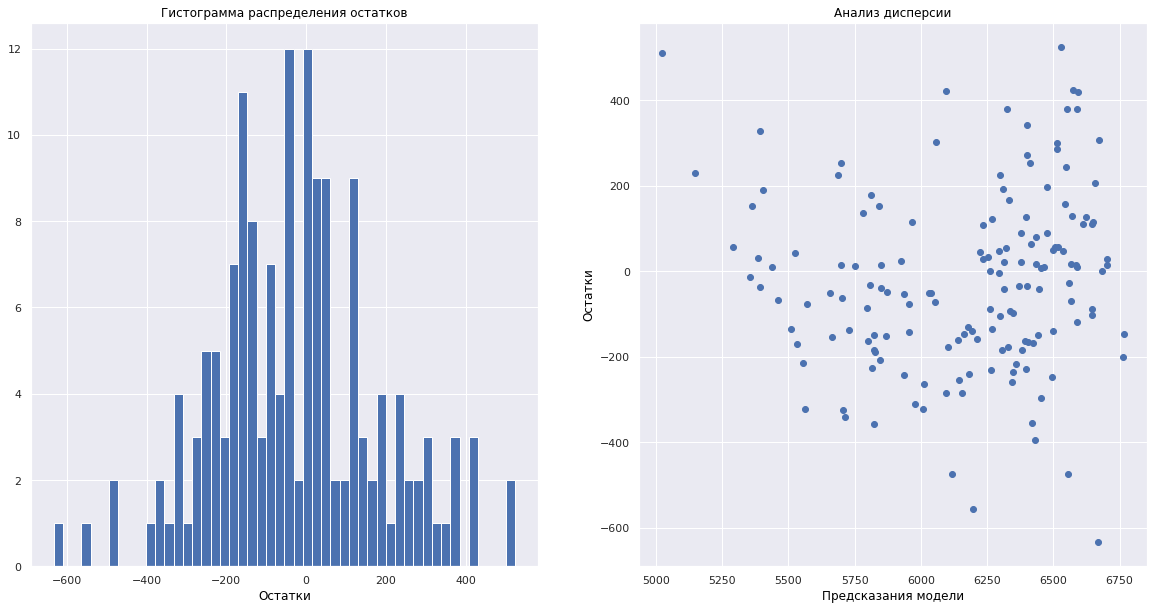

RMSE: 209.49228
MSE: 43887.01501
MAE: 164.24194
R²: 0.784

Описательная статистика ошибок
          удой_кг
count  157.000000
mean   -25.373286
std    208.615463
min   -632.814111
25%   -164.145968
50%    -34.294516
75%    108.696566
max    523.551641


In [83]:
num_col = ['эке', 'спо', 'сырой_протеин_г']
word_col = ['порода', 'возраст', 'порода_папы_быка', 'тип_пастбища']
delet = ['удой_кг']
y = ['удой_кг']


y_test, predictions, scaler, encoder, model_lr,  X_test_final = linal_ydoi(df=ferma_main, num_col=num_col, word_col=word_col, delet=delet, y=y)

grafic(y_test=y_test, predictions=predictions)

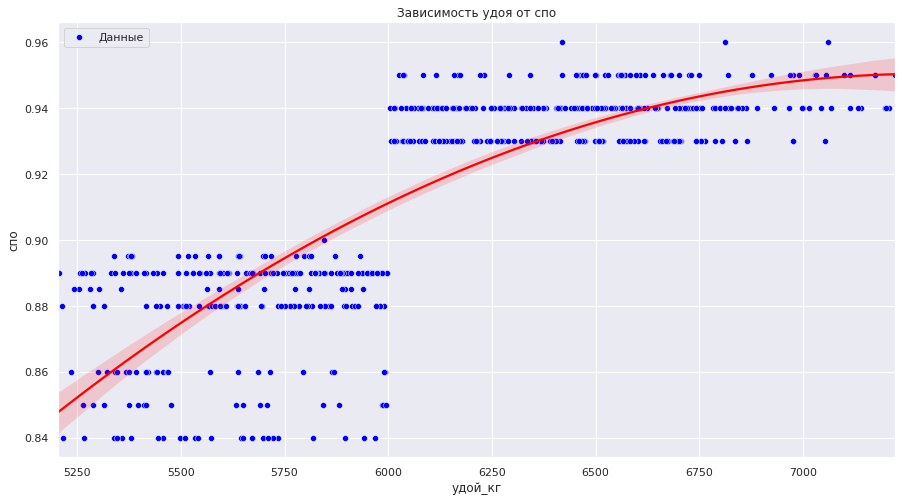

In [84]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x='удой_кг', y='спо', data=ferma_main, color='blue', label='Данные')
sns.regplot(x='удой_кг', y='спо', data=ferma_main, order=2, scatter=False, color='red', label='Нелинейная регрессия', ci=95) 

plt.title('Зависимость удоя от спо')
plt.xlabel('удой_кг')
plt.ylabel('спо')

plt.grid(True)
plt.show()

In [85]:
border = 0.9
ferma_main['спо_бинарный'] = (ferma_main['спо'] > border).astype(int)
ferma_main['эке_в_квадрате'] = ferma_main['эке'] ** 2

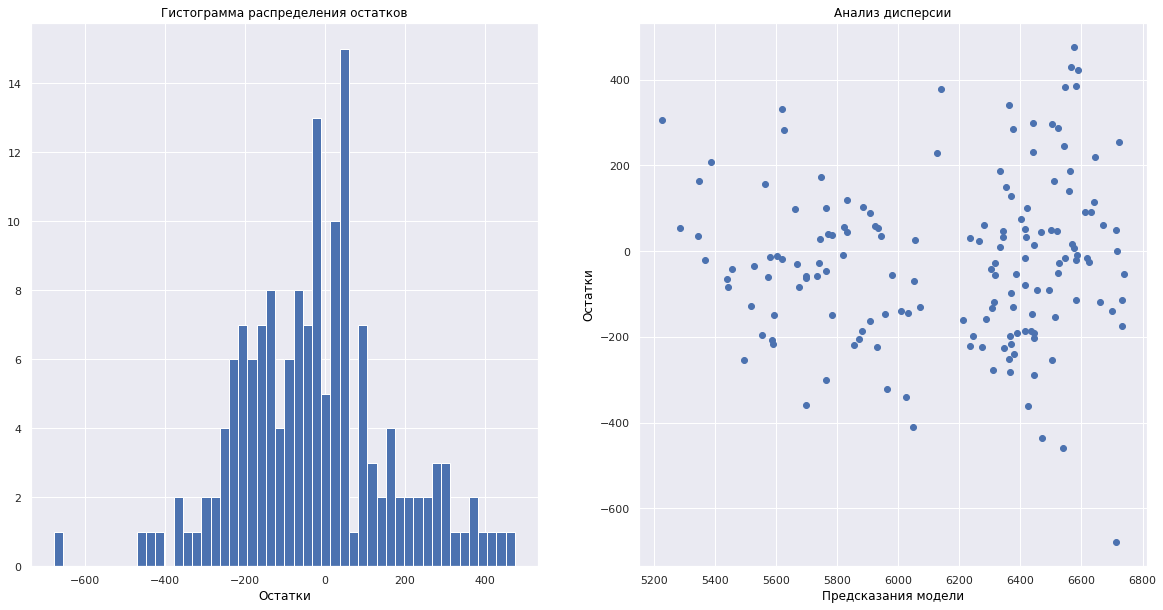

RMSE: 192.43417
MSE: 37030.91131
MAE: 149.03965
R²: 0.818

Описательная статистика ошибок
          удой_кг
count  157.000000
mean   -24.372798
std    191.495294
min   -677.411878
25%   -147.957591
50%    -27.871259
75%     60.191976
max    475.458320


In [86]:
num_col = ['эке_в_квадрате', 'сырой_протеин_г']
word_col = ['порода', 'возраст', 'порода_папы_быка', 'тип_пастбища', 'спо_бинарный']
delet = ['удой_кг']
y = ['удой_кг']

y_test, predictions, scaler, encoder, model_lr,  X_test_final = linal_ydoi(df=ferma_main, num_col=num_col, word_col=word_col, delet=delet, y=y)

grafic(y_test=y_test, predictions=predictions)

In [87]:
ferma_main = ferma_main.merge(ferma_dad, on='id', how='left')

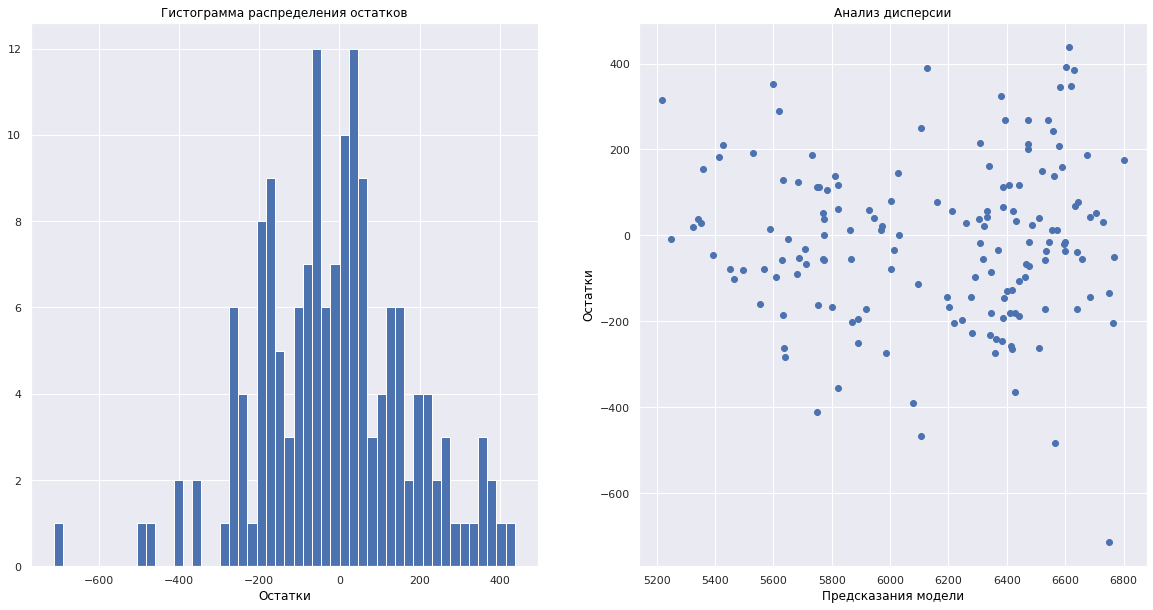

RMSE: 188.87533
MSE: 35673.88989
MAE: 146.16302
R²: 0.825

Описательная статистика ошибок
          удой_кг
count  157.000000
mean   -15.201522
std    188.865034
min   -712.793903
25%   -144.381634
50%    -15.967703
75%    112.027110
max    437.597704


In [88]:
num_col = ['эке_в_квадрате', 'сырой_протеин_г']
word_col = ['имя_папы', 'порода', 'возраст', 'порода_папы_быка', 'тип_пастбища', 'спо_бинарный']
delet = ['удой_кг']
y = ['удой_кг']

y_test, predictions, scaler, encoder, model_lr,  X_test_final = linal_ydoi(df=ferma_main, num_col=num_col, word_col=word_col, delet=delet, y=y)

grafic(y_test=y_test, predictions=predictions)

In [89]:
cow_buy['эке'] = ferma_main['эке'].mean()*1.05
cow_buy['эке_в_квадрате'] = cow_buy['эке']**2

cow_buy['сырой_протеин_г'] = ferma_main['сырой_протеин_г'].mean()*1.05
cow_buy['спо'] = ferma_main['спо'].mean()*1.05
cow_buy['спо_бинарный'] = (cow_buy['спо'] > 0.9).astype(int)

cow_buy['удой_кг'] = 0
cow_buy['возраст'] = (cow_buy['возраст'] == 'более_2_лет').astype(int)

cow_buy.head(20)

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст,эке,эке_в_квадрате,сырой_протеин_г,спо,спо_бинарный,удой_кг
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,15.276162,233.361138,2019.947532,0.958744,1,0
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,0,15.276162,233.361138,2019.947532,0.958744,1,0
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,15.276162,233.361138,2019.947532,0.958744,1,0
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,1,15.276162,233.361138,2019.947532,0.958744,1,0
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,1,15.276162,233.361138,2019.947532,0.958744,1,0
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,0,15.276162,233.361138,2019.947532,0.958744,1,0
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,15.276162,233.361138,2019.947532,0.958744,1,0
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,1,15.276162,233.361138,2019.947532,0.958744,1,0
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,15.276162,233.361138,2019.947532,0.958744,1,0
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,0,15.276162,233.361138,2019.947532,0.958744,1,0


In [ ]:
X_test = cow_buy  

num_col = ['эке_в_квадрате', 'сырой_протеин_г']
word_col = ['имя_папы', 'порода', 'возраст', 'порода_папы_быка', 'тип_пастбища', 'спо_бинарный']
delet = ['удой_кг']

X_test_features = X_test.drop(delet, axis=1)

X_test_num = scaler.transform(X_test_features[num_col])

X_test_cat = encoder.transform(X_test_features[word_col])
encoder_col_names = encoder.get_feature_names_out()

X_test_processed = pd.DataFrame(
    data=pd.concat([pd.DataFrame(X_test_num, columns=num_col), 
                    pd.DataFrame(X_test_cat, columns=encoder_col_names)], axis=1)
)
predictions = model_lr.predict(X_test_processed)
cow_buy = cow_buy.reset_index(drop=True)

cow_buy['удой_кг'] = predictions

cow_buy.head(20)

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст,эке,эке_в_квадрате,сырой_протеин_г,спо,спо_бинарный,удой_кг
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,15.276162,233.361138,2019.947532,0.958744,1,6609.919297
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,0,15.276162,233.361138,2019.947532,0.958744,1,6378.711028
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,15.276162,233.361138,2019.947532,0.958744,1,6283.999775
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,1,15.276162,233.361138,2019.947532,0.958744,1,6593.089377
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,1,15.276162,233.361138,2019.947532,0.958744,1,6542.146066
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,0,15.276162,233.361138,2019.947532,0.958744,1,6425.380218
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,15.276162,233.361138,2019.947532,0.958744,1,6609.919297
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,1,15.276162,233.361138,2019.947532,0.958744,1,6571.259737
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,15.276162,233.361138,2019.947532,0.958744,1,6283.999775
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,0,15.276162,233.361138,2019.947532,0.958744,1,6400.540668


Я обучил модели линейной регрессии на основе данных из файла farm_main.csv, и среди них была выбрана наиболее точная, основываясь на  метриках.

Коэффициент детерминации в лучшей модели составил 0.825, что приближает его к идеальному значению 1. Я выбрал эту модель.
В него входят признаки: 'эке_в_квадрате', 'сырой_протеин_г', 'имя_папы', 'порода', 'возраст', 'порода_папы_быка', 'тип_пастбища', 'спо_бинарный'.

Эта модель затем была использована для прогнозирования удоев коров на основе данных из файла cow_buy.csv.

В результате были выявлены 20 коров из ассоциации пастбищ "ЭкоФерма", у которых прогнозируемый удой составляет не менее 6000 кг в год. В целом все коровы могут давать больше 6000 кг удоя.

## Обучение модели логистической регрессии

In [91]:
ferma_main['вкус_молока'] = (ferma_main['вкус_молока'] == 'вкусно').astype(int)
cow_buy['вкус_молока'] = 0

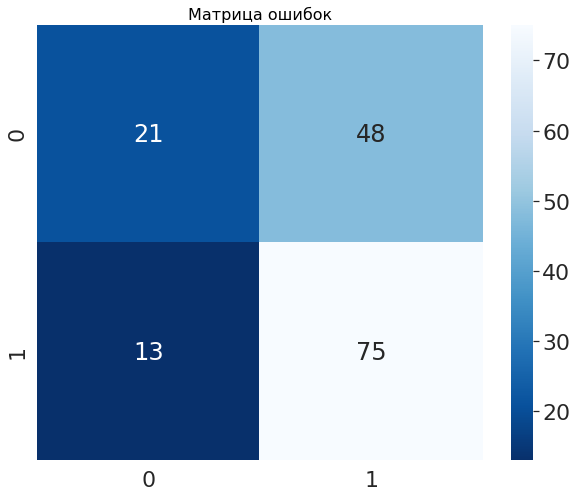

Accuracy =  0.611
Precision =  0.61
Recall =  0.852


In [ ]:
y = 'вкус_молока'
num_col = ['сырой_протеин_г', 'спо', 'эке_в_квадрате', 'жирность_%', 'белок_%']
word_col = ['порода_папы_быка', 'порода', 'тип_пастбища', 'возраст', 'имя_папы']
delet = ['вкус_молока']

X = ferma_main.drop(delet, axis=1)
y = ferma_main[y]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col])
X_test_scaled = scaler.transform(X_test[num_col])

encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[word_col])
X_test_ohe = encoder.transform(X_test[word_col])
encoder_col_names = encoder.get_feature_names_out(word_col)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_final = pd.concat([pd.DataFrame(X_train_scaled, columns=num_col), X_train_ohe.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_scaled, columns=num_col), X_test_ohe.reset_index(drop=True)], axis=1)

clf = LogisticRegression()

clf = clf.fit(X_train_final, y_train)

y_pred = clf.predict(X_test_final)

acc = accuracy_score(y_test, y_pred)  
precision = precision_score(y_test, y_pred) 
recall = recall_score(y_test, y_pred)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.set(font_scale=2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок', fontsize=16, fontweight='normal', color='black')
plt.show();

print('Accuracy = ', round(acc, 3))
print('Precision = ', round(precision, 3))
print('Recall = ', round(recall, 3))

Полнота прогноза не плохая Recall =  0.852 , но сама точность прогнозов низкая Accuracy =  0.611 и Precision =  0.61. В будущем мы поставим порог который устранит почти  до нуля ошибки FP.

In [ ]:
for feature_number, feature_name in enumerate(X_train_final.columns):
    weight = clf.coef_[0, feature_number]
    print(f"{feature_name:<20}: {weight:+.6f}") 

сырой_протеин_г     : +0.084974
спо                 : +0.198643
эке_в_квадрате      : +0.351675
жирность_%          : -0.139154
белок_%             : +0.245185
порода_папы_быка_Соверин: +0.073979
порода_РефлешнСоверинг: +0.034601
тип_пастбища_Холмистое: +0.489307
возраст_1           : +0.111753
имя_папы_Буйный     : -0.238639
имя_папы_Геркулес   : -0.194727
имя_папы_Соловчик   : -0.430447


In [ ]:
y_proba = clf.predict_proba(X_test_final)[:,1]

data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

data.head(10) 

,y_valid,y_proba
85,1,0.847825
110,1,0.822051
17,1,0.819704
116,0,0.812760
66,1,0.812487
114,1,0.808687
18,1,0.804516
33,0,0.801413
136,1,0.796864
14,1,0.795532


In [ ]:
thresholds = np.linspace(0.01, 1, num=2000, endpoint=False)
thresholds = [round(i, 2) for i in thresholds]

columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x>=i else 0

data.sample(5)

,y_valid,y_proba,y_pred_0.01,y_pred_0.02,y_pred_0.03,y_pred_0.04,y_pred_0.05,y_pred_0.06,y_pred_0.07,y_pred_0.08,...,y_pred_0.91,y_pred_0.92,y_pred_0.93,y_pred_0.94,y_pred_0.95,y_pred_0.96,y_pred_0.97,y_pred_0.98,y_pred_0.99,y_pred_1.0
71,0,0.510131,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
146,1,0.758514,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
46,0,0.289977,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13,1,0.713269,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
74,0,0.517947,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for i in thresholds:
    cm = confusion_matrix(y_test, data['y_pred_'+str(i)])
    if cm[0][1] == 0:
        print('Порог = ',i ,'Precision = ', round(precision_score(y_test, data['y_pred_'+str(i)]), 2), 'TP =', cm[1][1])
        porog = i
        break

Порог =  0.82 Precision =  1.0 TP = 2


In [97]:
porog = round(porog - 0.05, 2)

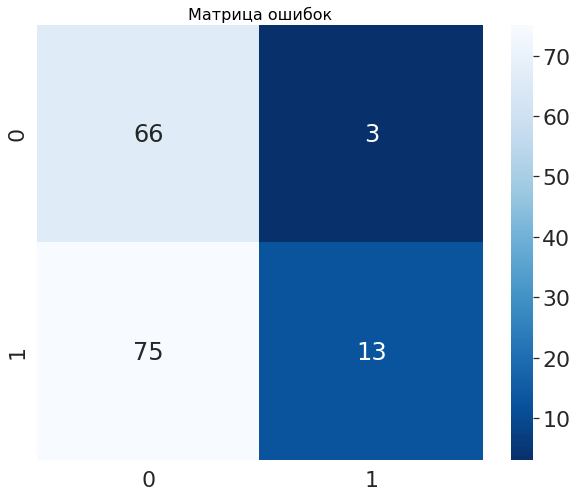

Accuracy =  0.503
Precision =  0.812
Recall =  0.148


In [ ]:
acc = accuracy_score(y_test, data['y_pred_'+str(porog)])  
precision = precision_score(y_test, data['y_pred_'+str(porog)]) 
recall = recall_score(y_test, data['y_pred_'+str(porog)])

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, data['y_pred_'+str(porog)])
sns.set(font_scale=2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок', fontsize=16, fontweight='normal', color='black')
plt.show();

print('Accuracy = ', round(acc, 3))
print('Precision = ', round(precision, 3))
print('Recall = ', round(recall, 3))

In [ ]:
X_test = cow_buy

X_test_features = X_test.drop(['вкус_молока'], axis=1)

X_test_num = scaler.transform(X_test_features[num_col])

X_test_cat = encoder.transform(X_test_features[word_col])
encoder_col_names = encoder.get_feature_names_out(word_col)

X_test_processed = pd.DataFrame(
    data=pd.concat([pd.DataFrame(X_test_num, columns=num_col),
                    pd.DataFrame(X_test_cat, columns=encoder_col_names)], axis=1)
)

y_pred = clf.predict_proba(X_test_processed)[:, 1]

cow_buy['y_pred'] = y_pred

cow_buy['вкус_молока'] = cow_buy['y_pred'].map(lambda x: 'вкусно' if x > porog else 'не вкусно')    
cow_buy = cow_buy.drop('y_pred', axis=1)

cow_buy.head(20) 

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст,эке,эке_в_квадрате,сырой_протеин_г,спо,спо_бинарный,удой_кг,вкус_молока
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,15.276162,233.361138,2019.947532,0.958744,1,6609.919297,не вкусно
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,0,15.276162,233.361138,2019.947532,0.958744,1,6378.711028,не вкусно
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,15.276162,233.361138,2019.947532,0.958744,1,6283.999775,не вкусно
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,1,15.276162,233.361138,2019.947532,0.958744,1,6593.089377,не вкусно
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,1,15.276162,233.361138,2019.947532,0.958744,1,6542.146066,не вкусно
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,0,15.276162,233.361138,2019.947532,0.958744,1,6425.380218,не вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,1,15.276162,233.361138,2019.947532,0.958744,1,6609.919297,не вкусно
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,1,15.276162,233.361138,2019.947532,0.958744,1,6571.259737,не вкусно
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,1,15.276162,233.361138,2019.947532,0.958744,1,6283.999775,не вкусно
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,0,15.276162,233.361138,2019.947532,0.958744,1,6400.540668,вкусно


Был сделан прогноз на основе данных и выбранного порога. Под такие стандарты на подошла одно корова. Она идеально подходит под условия задачи.

In [100]:
cow_buy['возраст'] = cow_buy['возраст'].map(lambda x: 'более_2_лет' if x == 1 else 'менее_2_лет')   
cow_buy = cow_buy.loc[cow_buy['вкус_молока'] == 'вкусно']
cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст,эке,эке_в_квадрате,сырой_протеин_г,спо,спо_бинарный,удой_кг,вкус_молока
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6400.540668,вкусно
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,15.276162,233.361138,2019.947532,0.958744,1,6127.474742,вкусно


Анализ показал, что при пороге 0.84 достигается нулевое значение критической ошибки FP. В этом случае количество истинно-положительных результатов TP составляет 3.

Оптимальным значением порога является 0.84, при котором критическая ошибка равняется 0.
Я выявил одну корову с целевым признаком вкуса молока, обозначенным как вкусно. 

## Итоговые выводы

Добрый день, коллеги, мы закончили наш проект по прогнозированию, ниже описано, чего мы смогли достигнуть:

1) В начале мы изменили и откоректировали данных. Критических ошибок не было найдено 5 дубликатов ferma_main и по удою 45000 кг. Все они были убраны, а данные приведены к общему значению.

2) В ходе обучения модели линейной регрессии мы использовали метод добавления новых признаков. Мы преобразовали спо в категориальный признак, что позволило выявить и использовать границу нелинейности в модели. Кроме того, введение нового признака "эке_в_квадрате" значительно улучшило точность предсказаний. Также было принято решение добавить категориальный признак "имя_папы", что способствовало достижению максимальной точности модели. На основе этой усовершенствованной модели мы смогли строить прогнозы по удоям коров ассоциации пастбищ "ЭкоФерма". 

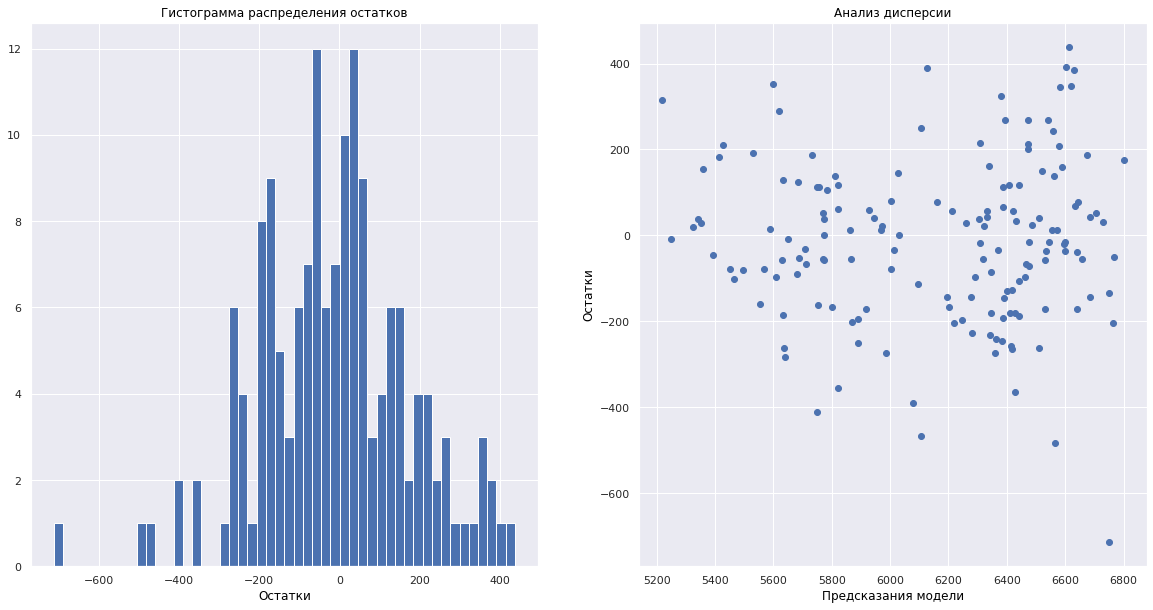

Ее разброс от -144 до 112

3) Мы создали модель логистической регрессии, опираясь на данные из датасета ferma_main.csv, и получили предсказания для целевого признака "вкус_молока". В ходе анализа были выявлены коровы, которые производят молоко с отличными вкусовыми качествами. Скомпилировав полученные данные, мы составили список из двух коров, соответствующих требованиям заказчика: их годовые удои превышают 6000 кг, и молоко у них "вкусное".

До порога:
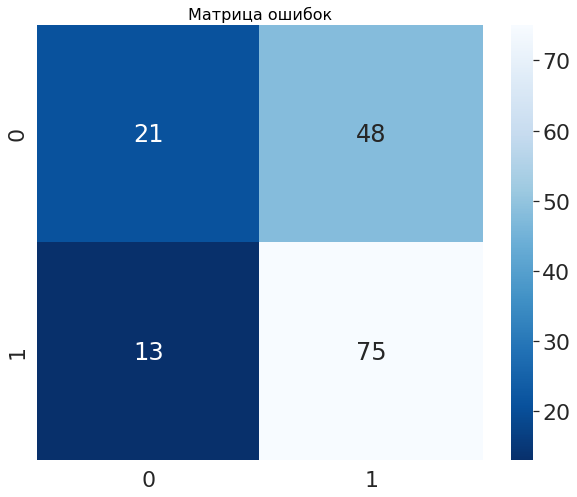

После порога:
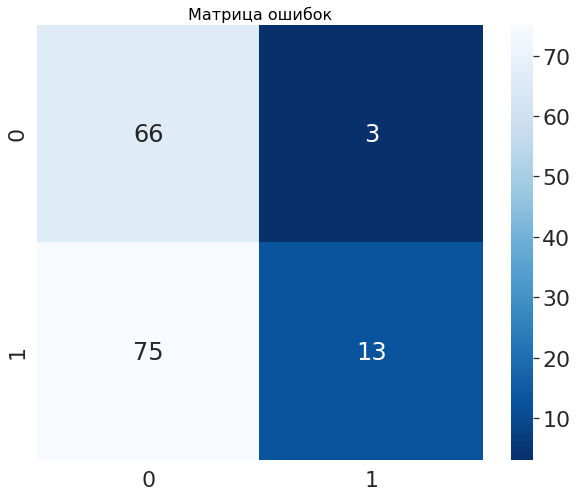

4) Анализ показал, что при пороге 0.77 достигается нулевое значение критической ошибки FP. 

5) Несмотря на полученные результаты, качество модели классификации остается на низком уровне. Это может свидетельствовать о нехватке входящих признаков. Рекомендуется провести дополнительный анализ данных и найти, что влияет на вкус молока. Зависит ли это от кормления, региона, время сбора молока или родство. 

Заключение для фермера:
Фермер может приобрести  одну молодую корову из стада, удовлетворяющих его требованиям по удоям и качеству молока, с минимальным риском. Однако важно учесть необходимость улучшения качества моделей для более надежных и точных предсказаний в будущем.

В данной ситуации я бы предложил уменьшить порог ошибки, чтобы фермер смог приобрести больше коров или изменить свойство покупаемых им коров например, чтобы они все былее молодые или более высокая жирность. Хотя больше всего вес имел спо, эке и тип пастбища.